<a href="https://colab.research.google.com/github/kkalyagina/epam/blob/main/Project_2month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

In [ ]:
! pip install -q kaggle

In [ ]:
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kristinakaliagina","key":"5ff793b37d31620470c022da3799aa82"}'}

In [ ]:
 ! mkdir ~/.kaggle

In [ ]:
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-04-27 07:28:41           3688  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           2130  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            449  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1366  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

In [ ]:
! kaggle competitions download -c competitive-data-science-predict-future-sales

 38% 5.00M/13.3M [00:00<00:00, 13.9MB/s]
100% 13.3M/13.3M [00:00<00:00, 29.9MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.10MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 142MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 151MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 115MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 10.9MB/s]


In [ ]:
! unzip items.csv.zip -d ./
! unzip sales_train.csv.zip -d ./
! unzip sample_submission.csv.zip -d ./
! unzip test.csv.zip -d ./

Archive:  items.csv.zip
  inflating: ./items.csv             
Archive:  sales_train.csv.zip
  inflating: ./sales_train.csv       
Archive:  sample_submission.csv.zip
  inflating: ./sample_submission.csv  
Archive:  test.csv.zip
  inflating: ./test.csv              


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import nbformat
from datetime import datetime, date
from sklearn.model_selection import TimeSeriesSplit
from collections import defaultdict
from itertools import product
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
import warnings
import itertools
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
from bokeh.io import output_notebook
output_notebook()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Download dataset

In [ ]:
sales = pd.read_csv("sales_train.csv")
items = pd.read_csv("./items.csv")
categories = pd.read_csv("./item_categories.csv")
shops = pd.read_csv("./shops.csv")
test = pd.read_csv("./test.csv")

# Sales:

date - date in format dd/mm/yyyy

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_price - current price of an item

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

# Items:

item_name - name of item

item_id - unique identifier of a product

item_category_id - unique identifier of item category

# Categories:

item_category_name - name of item category

item_category_id


# Shops:

shop_name - name of shop

shop_id - unique identifier of a shop

In [ ]:
cat_graph=categories.copy(deep=True)
cat_graph['item_category']=cat_graph['item_category_name'].str.split('-')
cat_graph['category']=cat_graph['item_category'].apply(lambda x: x[0].strip())
cat_graph['item'] = cat_graph['item_category'].apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cat_graph.drop(['item_category_name','item_category'], inplace=True, axis=1)

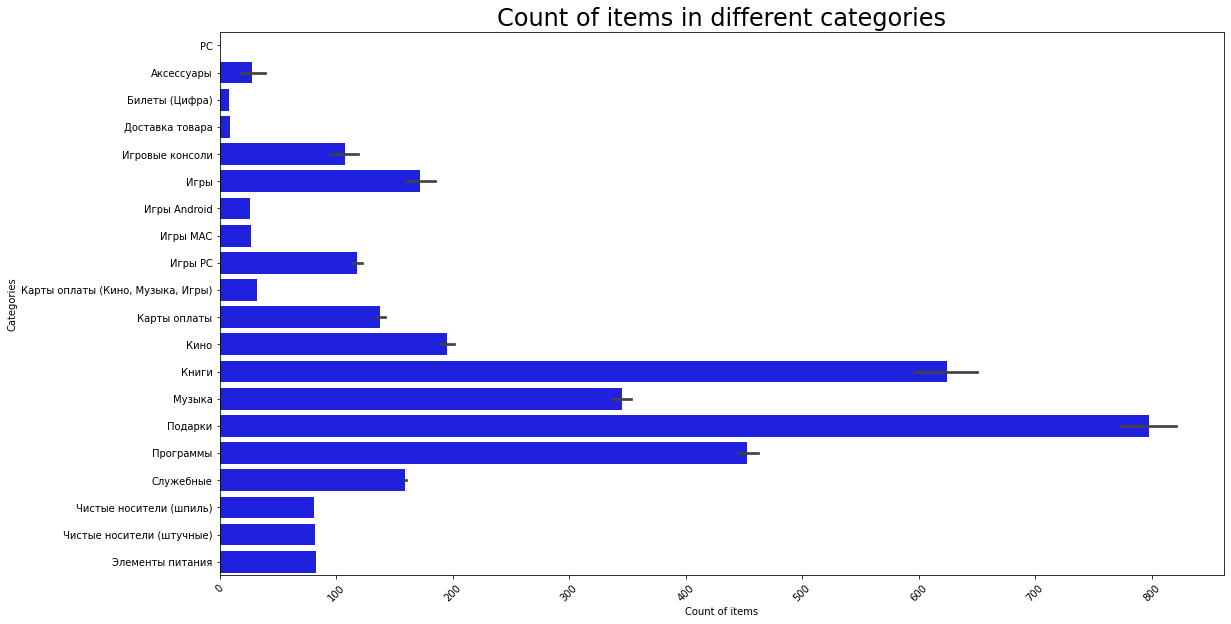

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Count of items in different categories', fontsize=24)
ax = sns.barplot(x='item_category_id', y='category', data=cat_graph, estimator=np.sum, color='b')
ax = ax.set(xlabel='Count of items', ylabel='Categories')
plt.xticks(rotation=45)
plt.show() 

# To merge datasets

In [ ]:
train = pd.merge(sales,
                    items[["item_id", "item_category_id"]],
                    how="inner",
                    on="item_id")

train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

test = pd.merge(test,
                   items[["item_id", "item_category_id"]],
                   how="inner",
                   on="item_id")

test["date_block_num"] = 34

In [ ]:
train

date  date_block_num  ...  item_cnt_day  item_category_id
0       2013-01-02               0  ...           1.0                37
1       2013-01-23               0  ...           1.0                37
2       2013-01-20               0  ...           1.0                37
3       2013-01-02               0  ...           1.0                37
4       2013-01-03               0  ...           1.0                37
...            ...             ...  ...           ...               ...
2935844 2015-10-17              33  ...           1.0                40
2935845 2015-10-01              33  ...           1.0                15
2935846 2015-10-29              33  ...           1.0                64
2935847 2015-10-22              33  ...           1.0                64
2935848 2015-10-01              33  ...           1.0                64

[2935849 rows x 7 columns]

In [ ]:
train.describe().T

count          mean  ...      75%       max
date_block_num    2935849.0     14.569911  ...     23.0      33.0
shop_id           2935849.0     33.001728  ...     47.0      59.0
item_id           2935849.0  10197.227057  ...  15684.0   22169.0
item_price        2935849.0    890.853233  ...    999.0  307980.0
item_cnt_day      2935849.0      1.242641  ...      1.0    2169.0
item_category_id  2935849.0     40.001383  ...     55.0      83.0

[6 rows x 8 columns]

min value of item_price = -1. It means that some product was returned. The same situation with item_cnt_day, namely 22 items were returned one day.

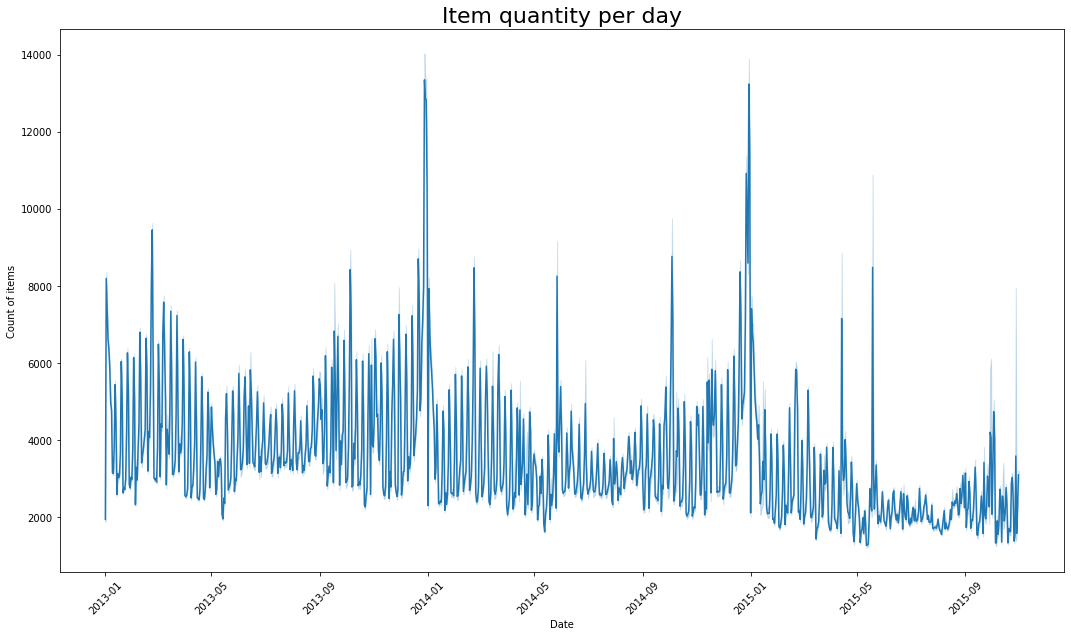

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item quantity per day', fontsize=22)
ax = sns.lineplot(x='date', y="item_cnt_day", data=train, estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items')
plt.xticks(rotation=45)
plt.show()

Seems that there is some seasonality pattern.

In [ ]:
# train["year"] = train.date.dt.year
# train["month"] = train.date.dt.month

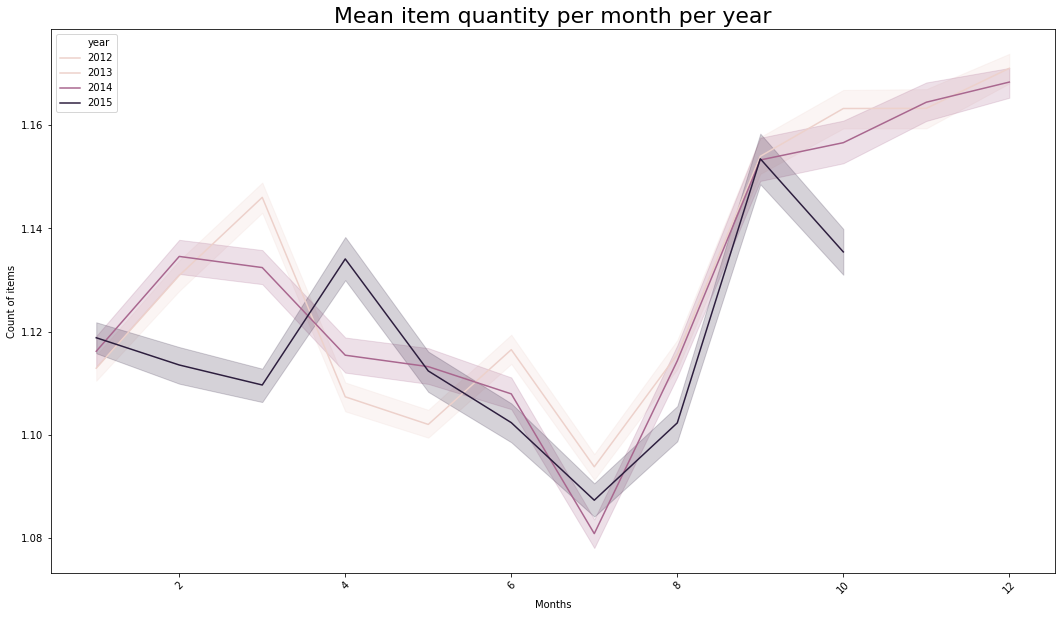

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Mean item quantity per month per year', fontsize=22)
ax = sns.lineplot(x='month', y="item_cnt_day", hue="year", data=train, estimator=np.mean)
ax = ax.set(xlabel='Months', ylabel='Count of items')
plt.xticks(rotation=45)
plt.show()


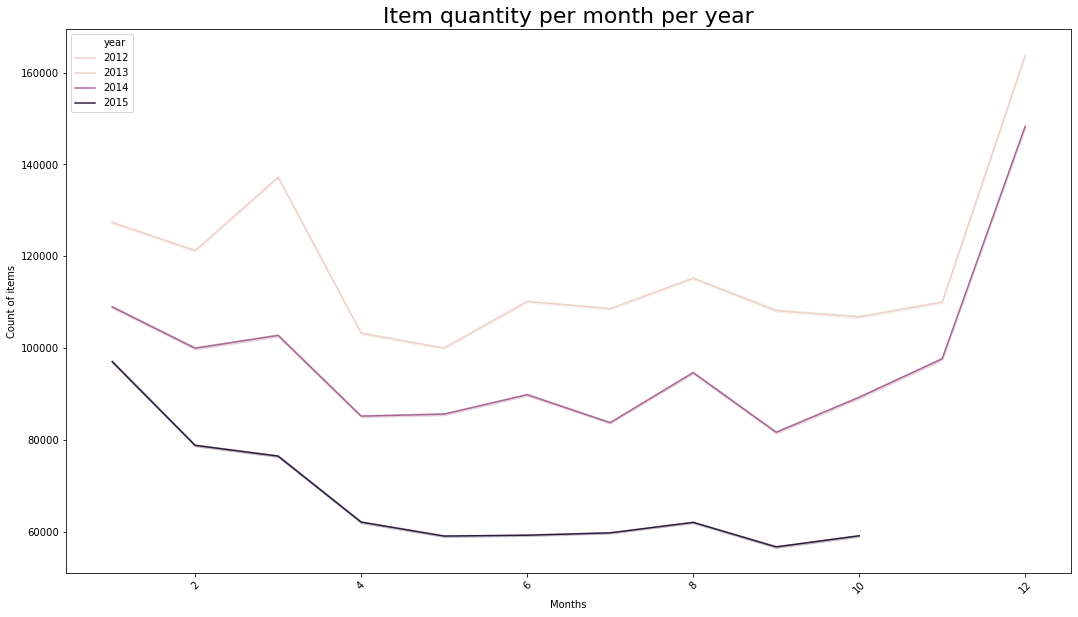

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item quantity per month per year', fontsize=22)
ax = sns.lineplot(x='month', y="item_cnt_day", hue="year", data=train, estimator=np.sum)
ax = ax.set(xlabel='Months', ylabel='Count of items')
plt.xticks(rotation=45)
plt.show()

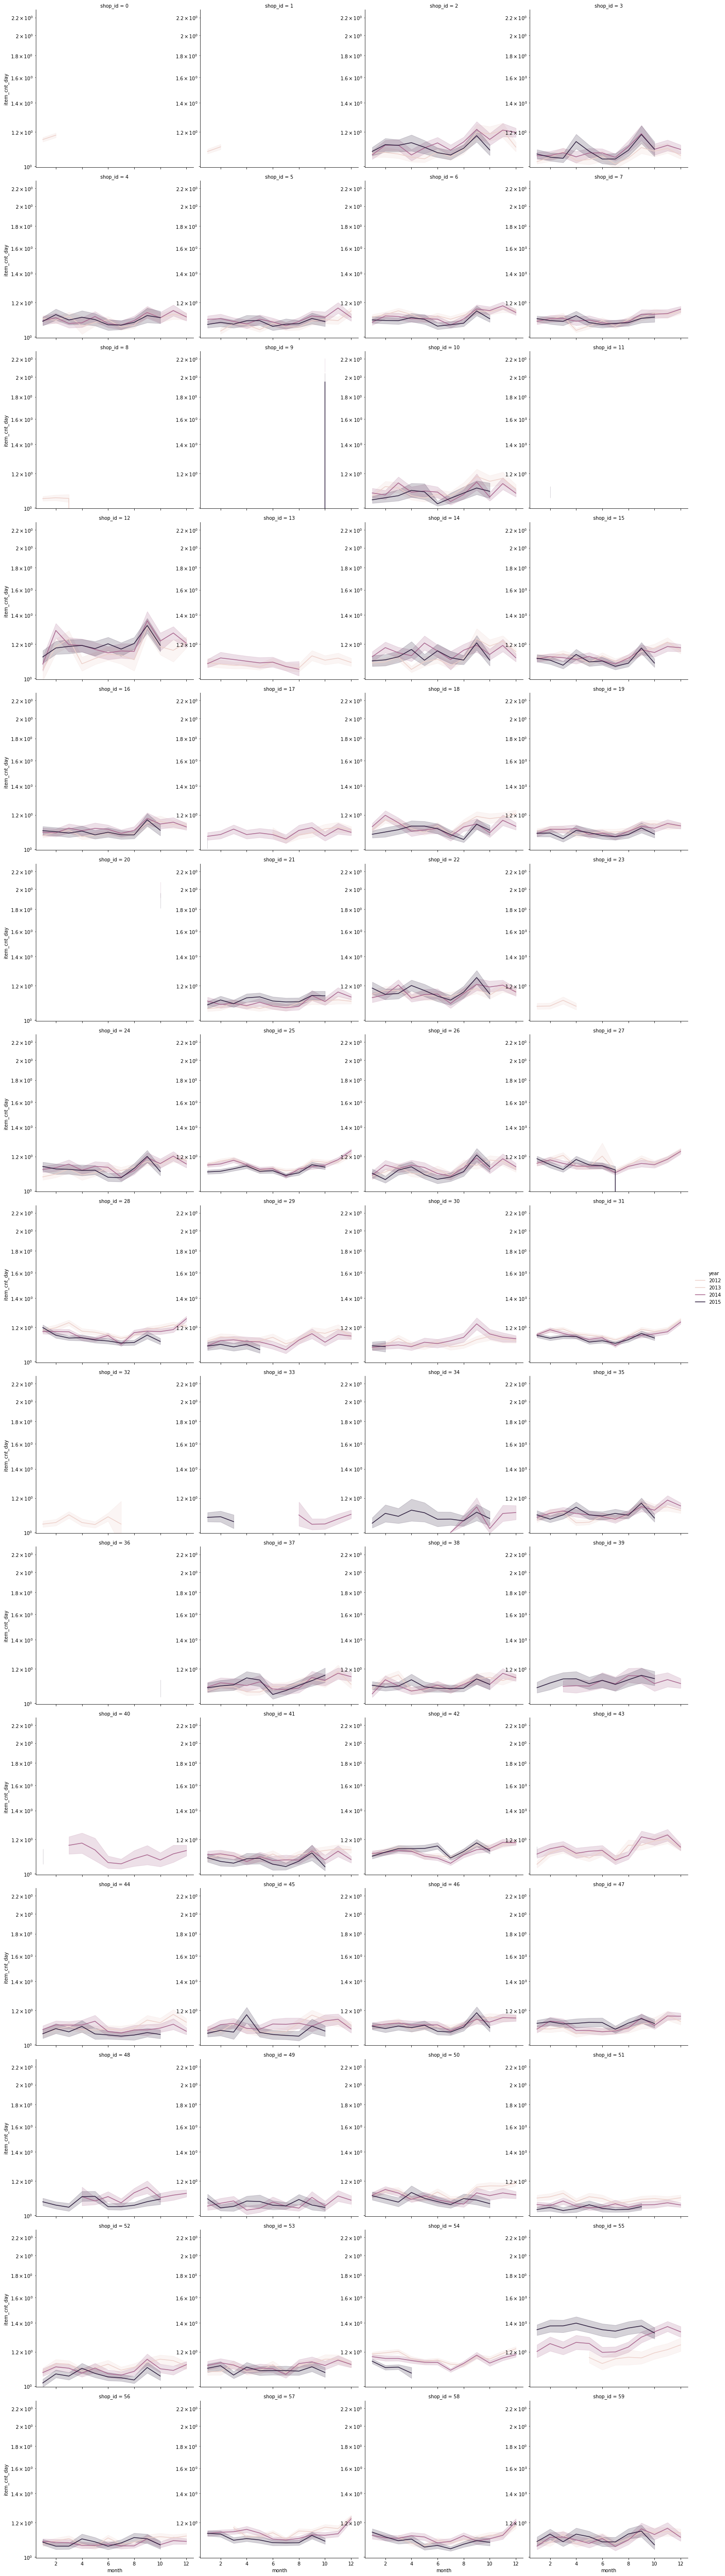

In [ ]:
# Mean Item Quantity Per Month Per Year

g = sns.relplot(x="month",
                y="item_cnt_day",
                kind="line",
                hue="year",
                col="shop_id",
                col_wrap=4,
                data=train,
                estimator="mean")

plt.yscale("log")

In [ ]:
def plot_missing_values_heatmap(df: pd.DataFrame) -> None:
  sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
  plt.title('Missing value in the dataset');


def get_mean_na_part(df: pd.DataFrame):
  return round((df.isna().sum() / df.shape[0]).mean(), 4)

EPSILON = 1e-10
def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted

def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error

    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)

def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))



def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))

def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))

по метрикам можно уточнить [тут](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d)

In [ ]:
train['year_month'] = train['date'].astype('datetime64[M]')

In [ ]:
train

date  date_block_num  ...  item_category_id  year_month
0       2013-01-02               0  ...                37  2013-01-01
1       2013-01-23               0  ...                37  2013-01-01
2       2013-01-20               0  ...                37  2013-01-01
3       2013-01-02               0  ...                37  2013-01-01
4       2013-01-03               0  ...                37  2013-01-01
...            ...             ...  ...               ...         ...
2935844 2015-10-17              33  ...                40  2015-10-01
2935845 2015-10-01              33  ...                15  2015-10-01
2935846 2015-10-29              33  ...                64  2015-10-01
2935847 2015-10-22              33  ...                64  2015-10-01
2935848 2015-10-01              33  ...                64  2015-10-01

[2935849 rows x 8 columns]

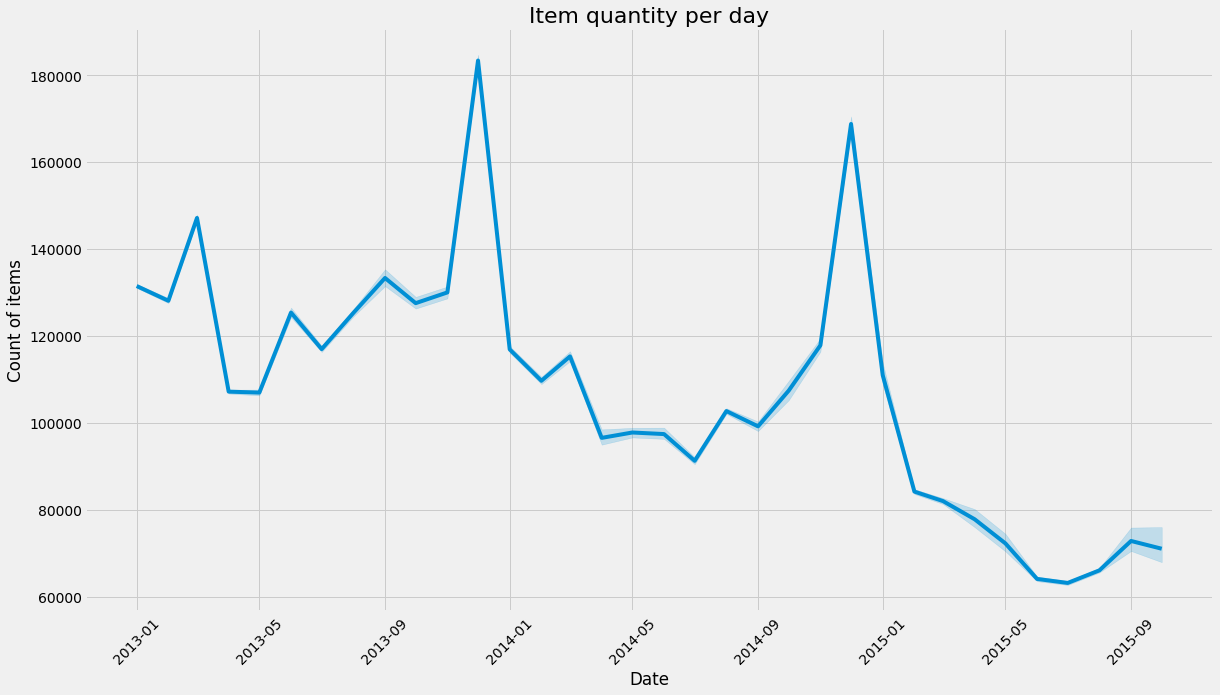

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item quantity per day', fontsize=22)
ax = sns.lineplot(x='year_month', y="item_cnt_day", data=train, estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items')
plt.xticks(rotation=45)
plt.show()

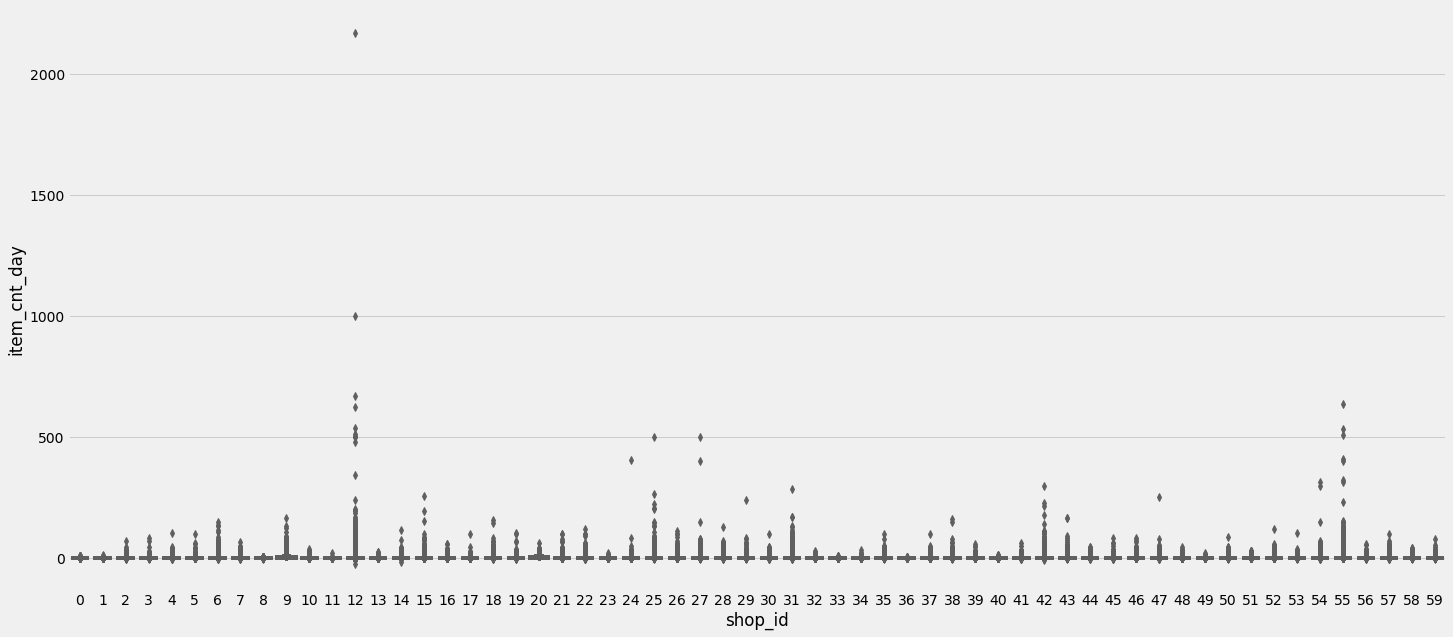

In [ ]:

f, axes = plt.subplots(figsize=(22, 10), sharex=True)
sns.boxplot(data=train, x='shop_id', y='item_cnt_day',palette="Set3")

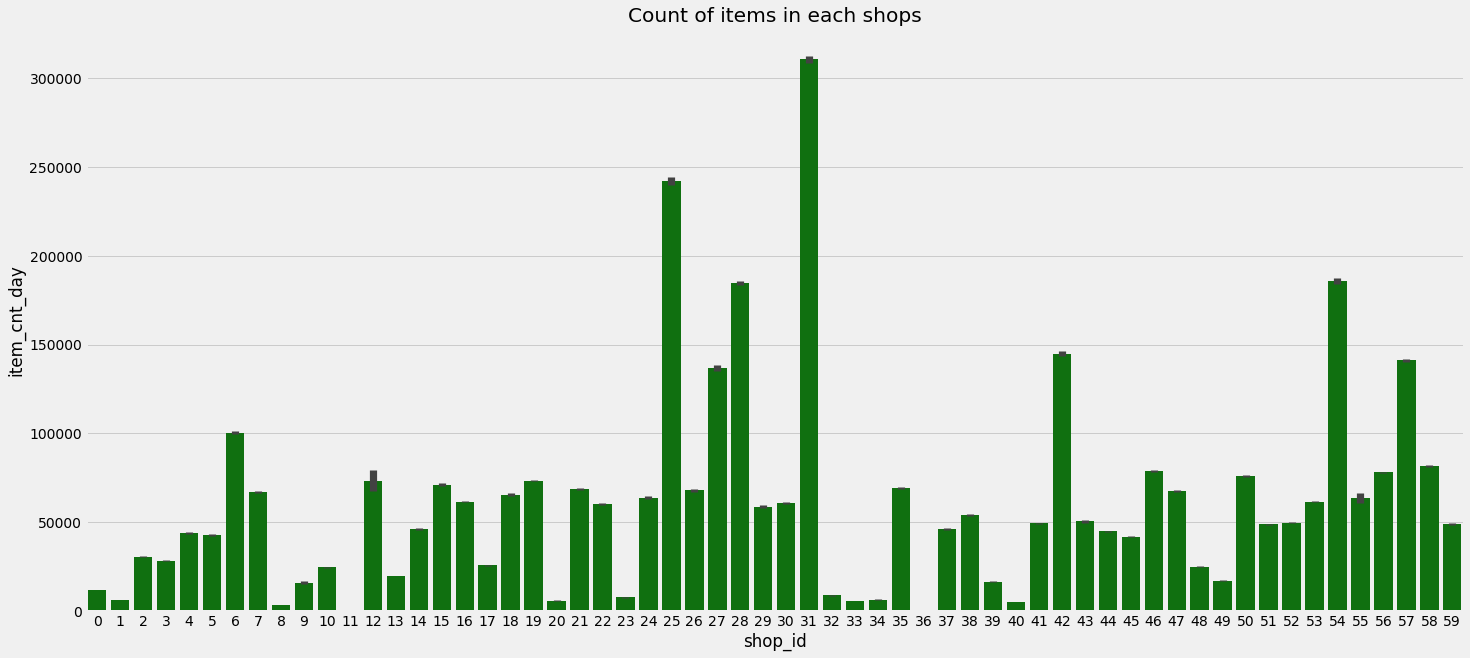

In [ ]:
f, axes = plt.subplots(figsize=(22, 10), sharex=True)
ax = sns.barplot(x="shop_id", y="item_cnt_day", data=train, estimator=np.sum, color='g').set_title("Count of items in each shops")
plt.show()


# Missing values

In [ ]:
train_super_id_sales_items = train[['shop_id','item_category_id', 'item_id', 'year_month', 'item_cnt_day']].groupby(['shop_id','item_category_id', 'item_id', 'year_month']).sum()
train_super_id_prices_items = train[['shop_id','item_category_id', 'item_id', 'year_month', 'item_price']].groupby(['shop_id','item_category_id', 'item_id', 'year_month']).sum()

train_super_id_sales_items = train_super_id_sales_items.unstack('year_month', fill_value=np.nan)
train_super_id_prices_items = train_super_id_prices_items.unstack('year_month', fill_value=np.nan)

In [ ]:
train_super_id_sales_items

item_cnt_day             ...                      
year_month                         2013-01-01 2013-02-01  ... 2015-09-01 2015-10-01
shop_id item_category_id item_id                          ...                      
0       0                16255            NaN        1.0  ...        NaN        NaN
        1                5740             NaN        1.0  ...        NaN        NaN
        2                5570             NaN        1.0  ...        NaN        NaN
                         5572            10.0       11.0  ...        NaN        NaN
                         5573             1.0        1.0  ...        NaN        NaN
...                                       ...        ...  ...        ...        ...
59      80               9254             NaN        NaN  ...        8.0        NaN
        83               22087            9.0        1.0  ...        3.0        6.0
                         22088            5.0        NaN  ...        1.0        2.0
                         22091            NaN        NaN  ...        3.0        1.0
                         22092            2.0        NaN  ...        NaN        NaN

[424124 rows x 34 columns]

In [ ]:
get_mean_na_part(train_super_id_sales_items), get_mean_na_part(train_super_id_prices_items)

в детализации до "shop-item" данные почти незаполнены. Но есть варианты подняться на иерархию выше: "shop-category" и "shop".
Посмотрим на полноту данных на уровне "shop-category":

In [ ]:
train_super_id_sales_category = train[['shop_id','item_category_id', 'year_month', 'item_cnt_day']].groupby(['shop_id','item_category_id', 'year_month']).sum()
train_super_id_prices_category = train[['shop_id','item_category_id',  'year_month', 'item_price']].groupby(['shop_id','item_category_id', 'year_month']).sum()

train_super_id_sales_category = train_super_id_sales_category.unstack('year_month', fill_value=np.nan)
train_super_id_prices_category = train_super_id_prices_category.unstack('year_month', fill_value=np.nan)

In [ ]:
train_super_id_sales_category

item_cnt_day             ...                      
year_month                 2013-01-01 2013-02-01  ... 2015-09-01 2015-10-01
shop_id item_category_id                          ...                      
0       0                         NaN        1.0  ...        NaN        NaN
        1                         NaN        1.0  ...        NaN        NaN
        2                        53.0       52.0  ...        NaN        NaN
        3                        28.0       24.0  ...        NaN        NaN
        4                        16.0       22.0  ...        NaN        NaN
...                               ...        ...  ...        ...        ...
59      75                       55.0       37.0  ...       11.0       12.0
        77                        NaN        NaN  ...        NaN        NaN
        79                        NaN        3.0  ...       12.0       13.0
        80                        NaN        NaN  ...       22.0        NaN
        83                       16.0        1.0  ...        7.0        9.0

[3271 rows x 34 columns]

In [ ]:
get_mean_na_part(train_super_id_sales_category), get_mean_na_part(train_super_id_prices_category)

(0.4138, 0.4138)

тут можно посмотреть что это за категории, которые хорошо покупаются (визуализация)

In [ ]:
train_super_id_sales_category=train_super_id_sales_category.T

In [ ]:
train_super_id_sales_category

shop_id                   0                    ...   59                  
item_category_id          0    1     2     3   ...   77    79    80    83
             year_month                        ...                       
item_cnt_day 2013-01-01  NaN  NaN  53.0  28.0  ...  NaN   NaN   NaN  16.0
             2013-02-01  1.0  1.0  52.0  24.0  ...  NaN   3.0   NaN   1.0
             2013-03-01  NaN  NaN   NaN   NaN  ...  NaN   NaN   NaN  17.0
             2013-04-01  NaN  NaN   NaN   NaN  ...  NaN   NaN   NaN   5.0
             2013-05-01  NaN  NaN   NaN   NaN  ...  1.0   NaN   NaN  15.0
             2013-06-01  NaN  NaN   NaN   NaN  ...  NaN   NaN   NaN  25.0
             2013-07-01  NaN  NaN   NaN   NaN  ...  NaN   NaN   NaN  28.0
             2013-08-01  NaN  NaN   NaN   NaN  ...  NaN   NaN   NaN  16.0
             2013-09-01  NaN  NaN   NaN   NaN  ...  NaN   NaN   NaN  19.0
             2013-10-01  NaN  NaN   NaN   NaN  ...  NaN   NaN   NaN  12.0
             2013-11-01  NaN  NaN   NaN   NaN  ...  NaN   5.0   NaN  26.0
             2013-12-01  NaN  NaN   NaN   NaN  ...  NaN   NaN   NaN  48.0
             2014-01-01  NaN  NaN   NaN   NaN  ...  NaN   NaN   NaN  16.0
             2014-02-01  NaN  NaN   NaN   NaN  ...  2.0   NaN   NaN   9.0
             2014-03-01  NaN  NaN   NaN   NaN  ...  NaN   NaN   NaN  12.0
             2014-04-01  NaN  NaN   NaN   NaN  ...  NaN   NaN   NaN   7.0
             2014-05-01  NaN  NaN   NaN   NaN  ...  NaN   NaN   NaN  17.0
             2014-06-01  NaN  NaN   NaN   NaN  ...  NaN   2.0   NaN  18.0
             2014-07-01  NaN  NaN   NaN   NaN  ...  NaN   5.0   NaN  23.0
             2014-08-01  NaN  NaN   NaN   NaN  ...  NaN  20.0   NaN  18.0
             2014-09-01  NaN  NaN   NaN   NaN  ...  NaN  27.0   NaN  22.0
             2014-10-01  NaN  NaN   NaN   NaN  ...  NaN  21.0   NaN  16.0
             2014-11-01  NaN  NaN   NaN   NaN  ...  NaN  46.0   NaN  25.0
             2014-12-01  NaN  NaN   NaN   NaN  ...  NaN  34.0   NaN  30.0
             2015-01-01  NaN  NaN   NaN   NaN  ...  NaN  27.0   NaN  14.0
             2015-02-01  NaN  NaN   NaN   NaN  ...  NaN  22.0   NaN  13.0
             2015-03-01  NaN  NaN   NaN   NaN  ...  1.0  26.0   NaN  13.0
             2015-04-01  NaN  NaN   NaN   NaN  ...  NaN  19.0   NaN   5.0
             2015-05-01  NaN  NaN   NaN   NaN  ...  NaN  13.0   NaN   5.0
             2015-06-01  NaN  NaN   NaN   NaN  ...  NaN  10.0   NaN   5.0
             2015-07-01  NaN  NaN   NaN   NaN  ...  NaN  24.0   6.0  12.0
             2015-08-01  NaN  NaN   NaN   NaN  ...  NaN  16.0   2.0  10.0
             2015-09-01  NaN  NaN   NaN   NaN  ...  NaN  12.0  22.0   7.0
             2015-10-01  NaN  NaN   NaN   NaN  ...  NaN  13.0   NaN   9.0

[34 rows x 3271 columns]

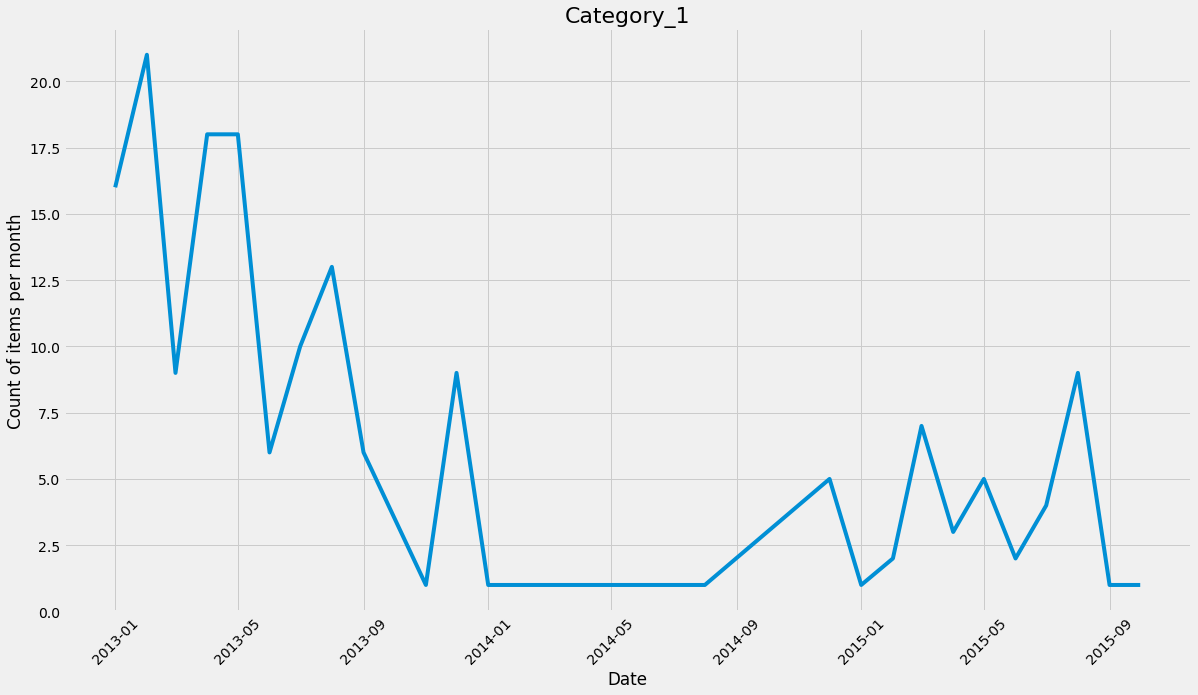

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Category_1', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_category[59][25], data=train_super_id_sales_category[59][25], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

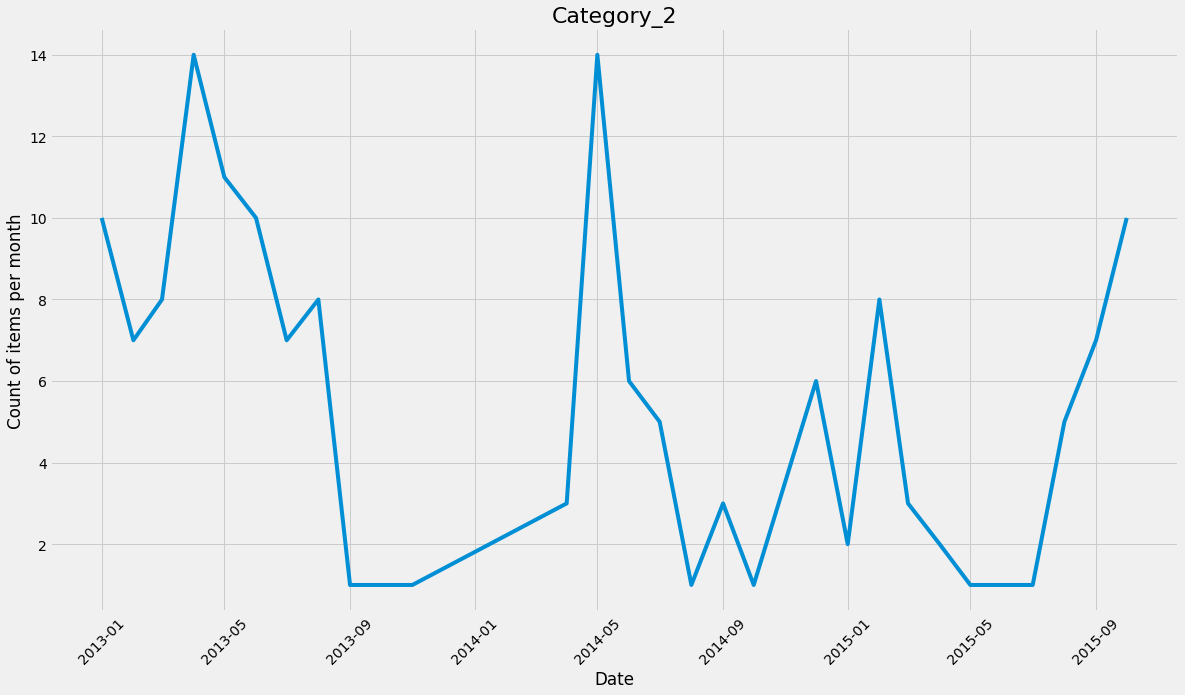

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Category_2', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_category[45][25], data=train_super_id_sales_category[45][25], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

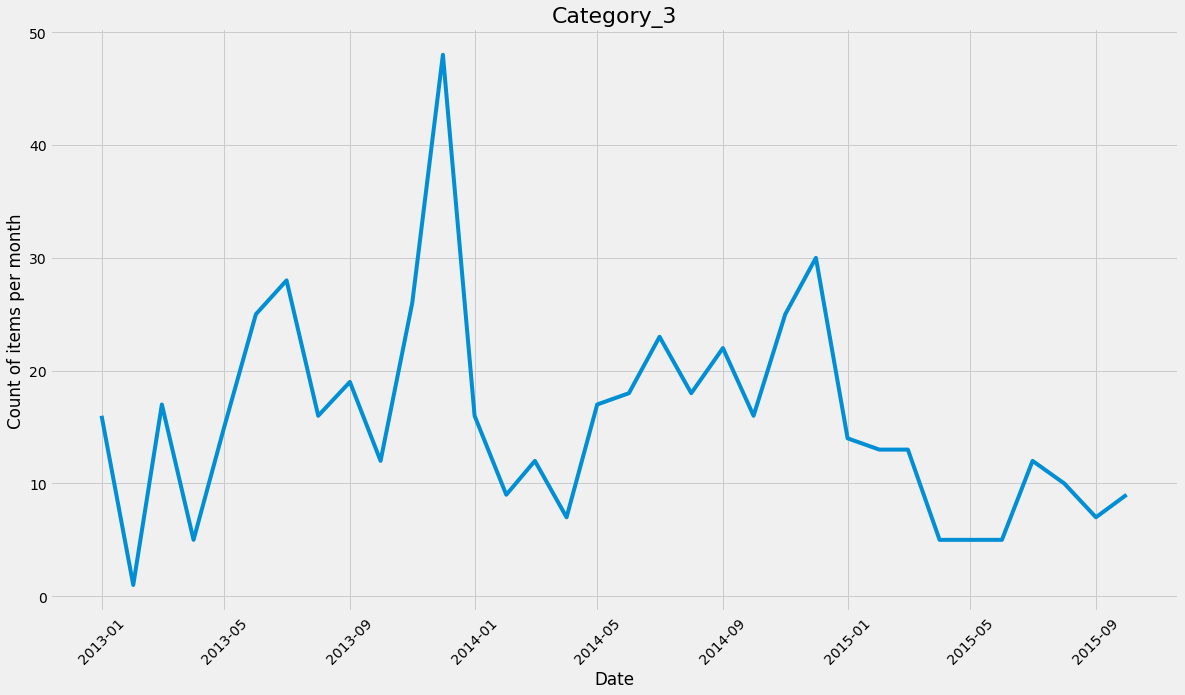

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Category_3', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_category[59][83], data=train_super_id_sales_category[59][83], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

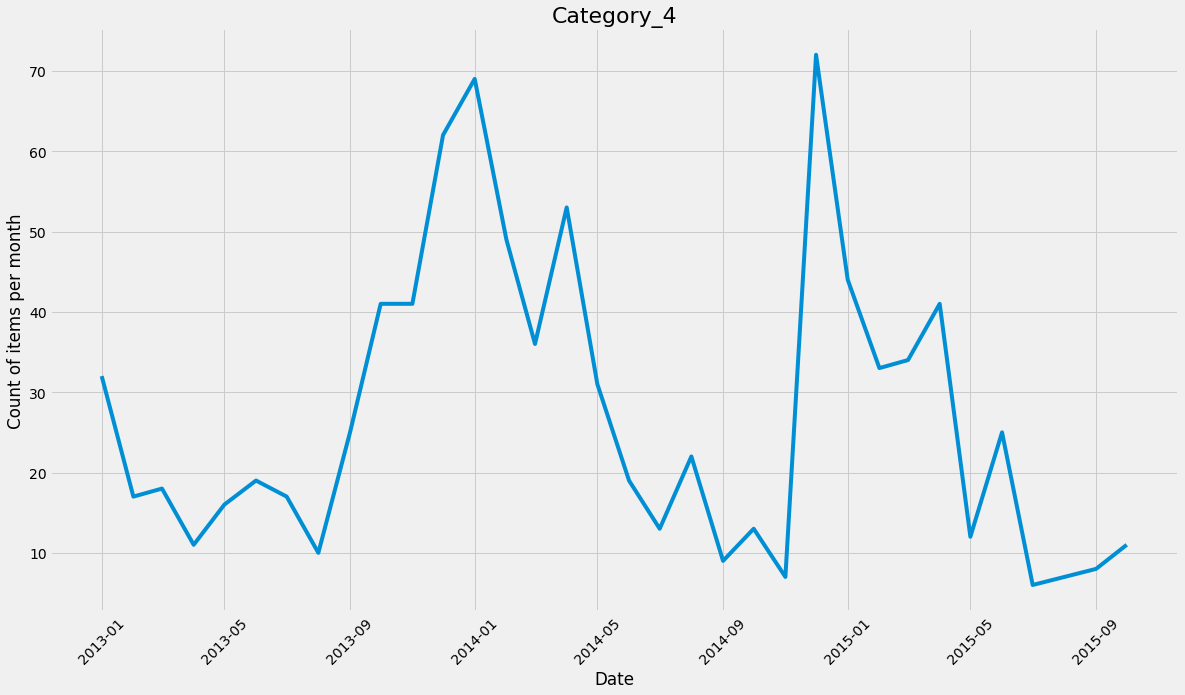

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Category_4', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_category[25][25], data=train_super_id_sales_category[25][25], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

In [ ]:
train_super_id_sales_category.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 34 entries, ('item_cnt_day', Timestamp('2013-01-01 00:00:00')) to ('item_cnt_day', Timestamp('2015-10-01 00:00:00'))
Columns: 3271 entries, (0, 0) to (59, 83)
dtypes: float64(3271)
memory usage: 870.6+ KB


Посмотрим на полноту данных на уровне "shop":

In [ ]:
train_super_id_sales_shop = train[['shop_id', 'year_month', 'item_cnt_day']].groupby(['shop_id', 'year_month']).sum()

train_super_id_sales_shop = train_super_id_sales_shop.unstack('year_month', fill_value=np.nan)

train_super_id_sales_shop.columns = train_super_id_sales_shop.columns.droplevel()

In [ ]:
train_super_id_sales_shop

year_month  2013-01-01  2013-02-01  ...  2015-09-01  2015-10-01
shop_id                             ...                        
0               5578.0      6127.0  ...         NaN         NaN
1               2947.0      3364.0  ...         NaN         NaN
2               1146.0       488.0  ...       822.0       727.0
3                767.0       798.0  ...       745.0       613.0
4               2114.0      2025.0  ...       732.0       831.0
5                  NaN       877.0  ...      1092.0      1052.0
6               3686.0      4007.0  ...      1725.0      1802.0
7               2495.0      2513.0  ...      1287.0      1212.0
8               1463.0      1156.0  ...         NaN         NaN
9                  NaN         NaN  ...         NaN      3186.0
10               935.0      1026.0  ...       519.0       428.0
11                 NaN         NaN  ...         NaN         NaN
12               842.0      1209.0  ...      5215.0      4181.0
13              1178.0      1036.0  ...         NaN         NaN
14              1777.0      1795.0  ...      1094.0      1002.0
15              2724.0      2746.0  ...      1267.0      1243.0
16              2978.0      2614.0  ...      1067.0       963.0
17                 NaN         NaN  ...         NaN         NaN
18              2856.0      3341.0  ...      1404.0      1211.0
19              3038.0      2834.0  ...      1231.0      1449.0
20                 NaN         NaN  ...         NaN      2611.0
21              1495.0      1854.0  ...      1900.0      1912.0
22              1924.0      2447.0  ...      1432.0      1336.0
23              1948.0      1941.0  ...         NaN         NaN
24              1768.0      1782.0  ...      1492.0      1227.0
25              8215.0      7934.0  ...      5893.0      6247.0
26              2331.0      2597.0  ...      1553.0      1409.0
27              5548.0      4546.0  ...        -1.0         NaN
28              7057.0      5438.0  ...      2979.0      3018.0
29              2820.0      2834.0  ...         NaN         NaN
30              2978.0      2717.0  ...         NaN         NaN
31             10173.0     11160.0  ...      6505.0      6112.0
32              1238.0      1494.0  ...         NaN         NaN
33                 NaN         NaN  ...         NaN         NaN
34                 NaN         NaN  ...       420.0       383.0
35              2127.0      2205.0  ...      1548.0      1418.0
36                 NaN         NaN  ...         NaN       330.0
37              2399.0      2216.0  ...       978.0       833.0
38              1704.0      1670.0  ...      1345.0      1110.0
39                 NaN         NaN  ...       907.0       997.0
40                 NaN         NaN  ...         NaN         NaN
41              1998.0      1856.0  ...       686.0       742.0
42              3991.0      3965.0  ...      4237.0      4491.0
43              1759.0      2033.0  ...         NaN         NaN
44              1708.0      1823.0  ...       759.0       779.0
45              1634.0      1530.0  ...       654.0       702.0
46              3363.0      2660.0  ...      1357.0      1320.0
47              2115.0      1824.0  ...      1926.0      1776.0
48                 NaN         NaN  ...      1101.0      1111.0
49                 NaN         NaN  ...       567.0       648.0
50              3406.0      3054.0  ...       906.0       949.0
51              2748.0      2284.0  ...       624.0         NaN
52              1812.0      1737.0  ...      1086.0       847.0
53              2055.0      1906.0  ...      1229.0      1061.0
54              9386.0      8075.0  ...         NaN         NaN
55                 NaN         NaN  ...      6867.0      1972.0
56              3238.0      2655.0  ...      1194.0      1263.0
57                 NaN         NaN  ...      2266.0      2316.0
58                 NaN         NaN  ...      1319.0      1446.0
59              2017.0      1897.0  ...       914.0       790.0

[60 rows x 34 columns]

In [ ]:
get_mean_na_part(train_super_id_sales_shop)

0.2225

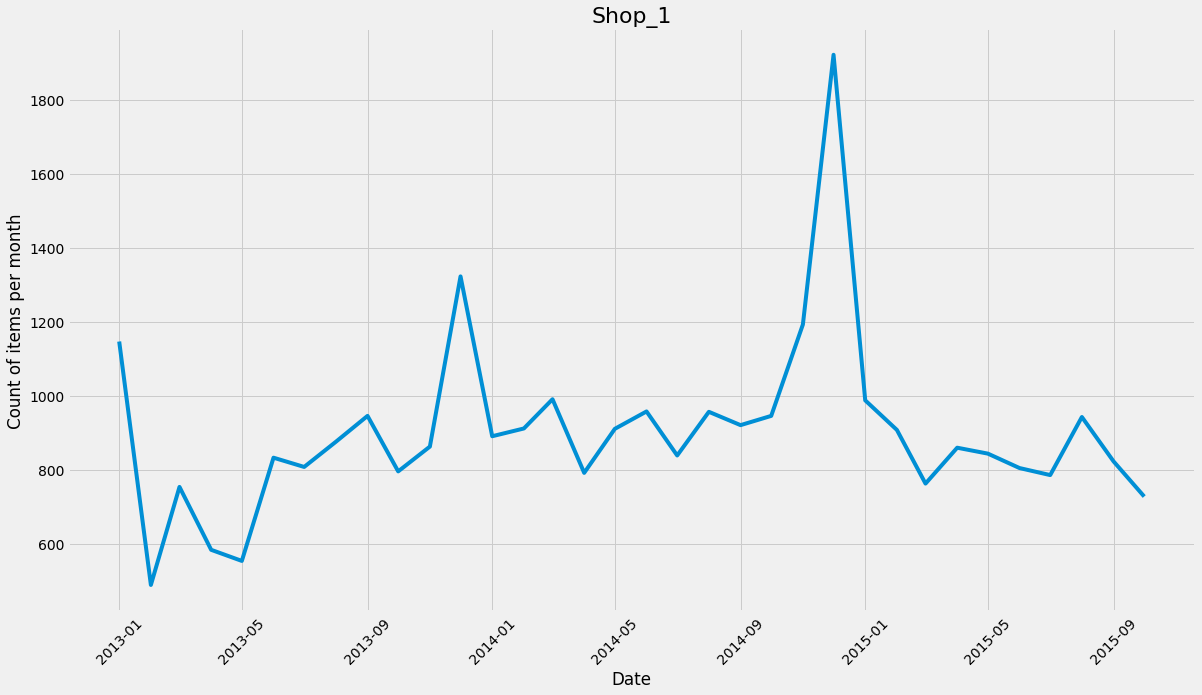

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Shop_1', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_shop.T[2], data=train_super_id_sales_shop.T[2], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

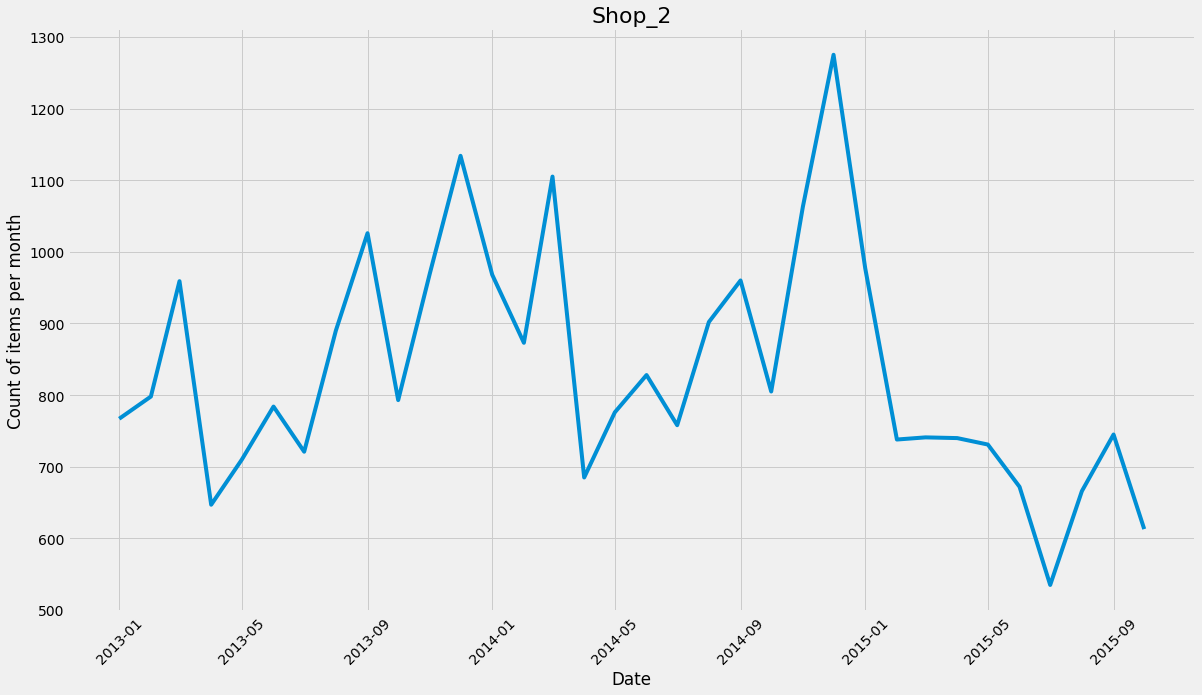

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Shop_2', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_shop.T[3], data=train_super_id_sales_shop.T[3], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

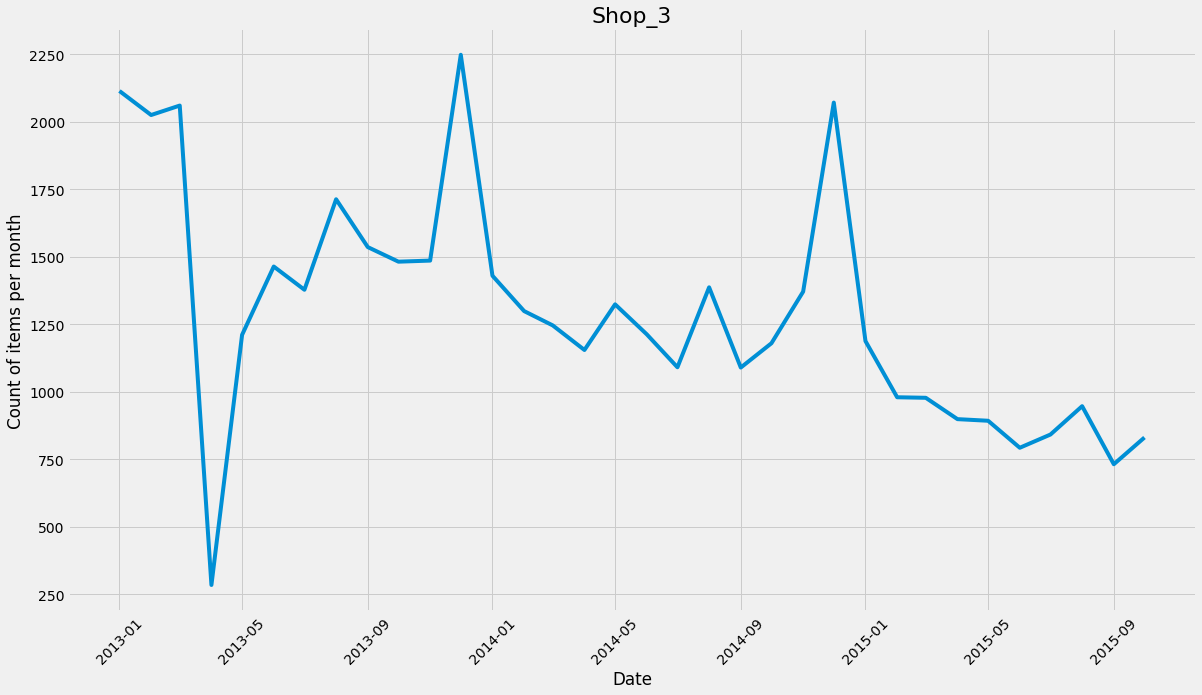

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Shop_3', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_shop.T[4], data=train_super_id_sales_shop.T[4], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

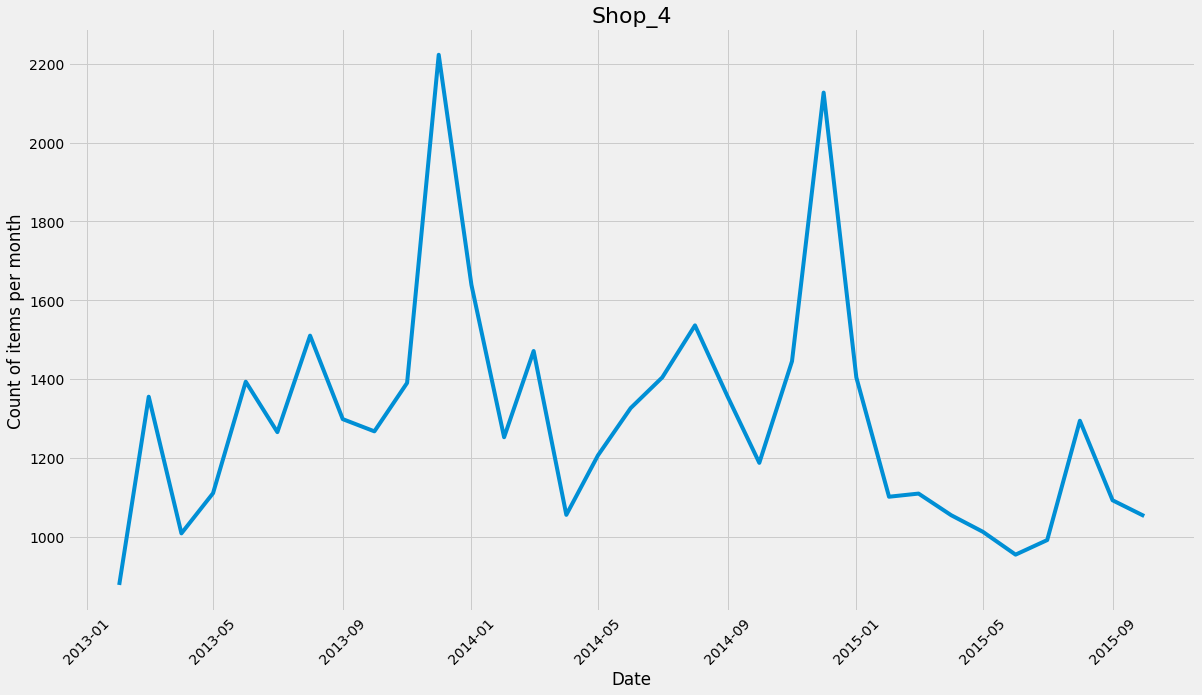

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Shop_4', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_shop.T[5], data=train_super_id_sales_shop.T[5], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

In [ ]:
train_super_id_sales_category = train[['shop_id','item_category_id', 'year_month', 'item_cnt_day']].groupby(['shop_id','item_category_id', 'year_month']).sum()

train_super_id_sales_category = train_super_id_sales_category.unstack('year_month', fill_value=np.nan)

train_super_id_sales_category.columns = train_super_id_sales_category.columns.droplevel()

In [ ]:
train_super_id_sales_category

In [ ]:
get_mean_na_part(train_super_id_sales_category)

0.4138

In [ ]:
train_super_id_sales_items = train[['shop_id','item_category_id', 'item_id', 'year_month', 'item_cnt_day']].groupby(['shop_id','item_category_id', 'item_id', 'year_month']).sum()

train_super_id_sales_items = train_super_id_sales_items.unstack('year_month', fill_value=np.nan)

train_super_id_sales_items.columns = train_super_id_sales_items.columns.droplevel()

In [ ]:
train_super_id_sales_items

year_month                        2013-01-01  ...  2015-10-01
shop_id item_category_id item_id              ...            
0       0                16255           NaN  ...         NaN
        1                5740            NaN  ...         NaN
        2                5570            NaN  ...         NaN
                         5572           10.0  ...         NaN
                         5573            1.0  ...         NaN
...                                      ...  ...         ...
59      80               9254            NaN  ...         NaN
        83               22087           9.0  ...         6.0
                         22088           5.0  ...         2.0
                         22091           NaN  ...         1.0
                         22092           2.0  ...         NaN

[424124 rows x 34 columns]

In [ ]:
get_mean_na_part(train_super_id_sales_items)

0.8884

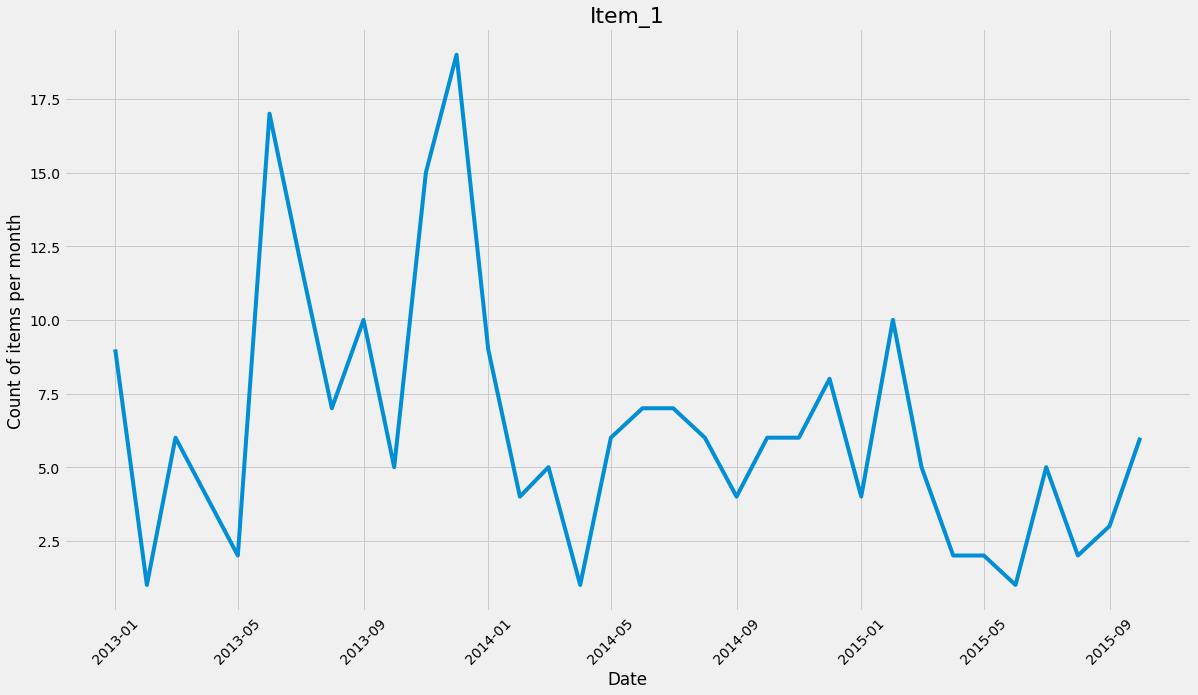

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item_1', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_items.T[59][83][22087], data=train_super_id_sales_items.T[59][83][22087], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

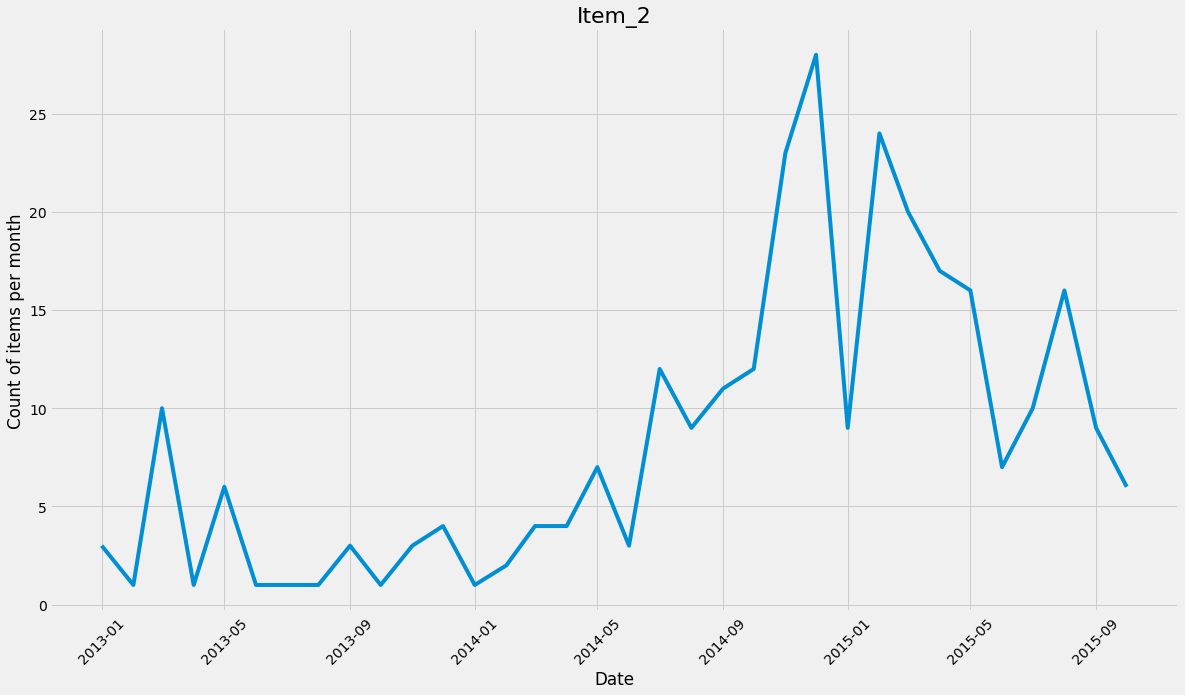

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item_2', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_items.T[18][79][17717], data=train_super_id_sales_items.T[18][79][17717], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

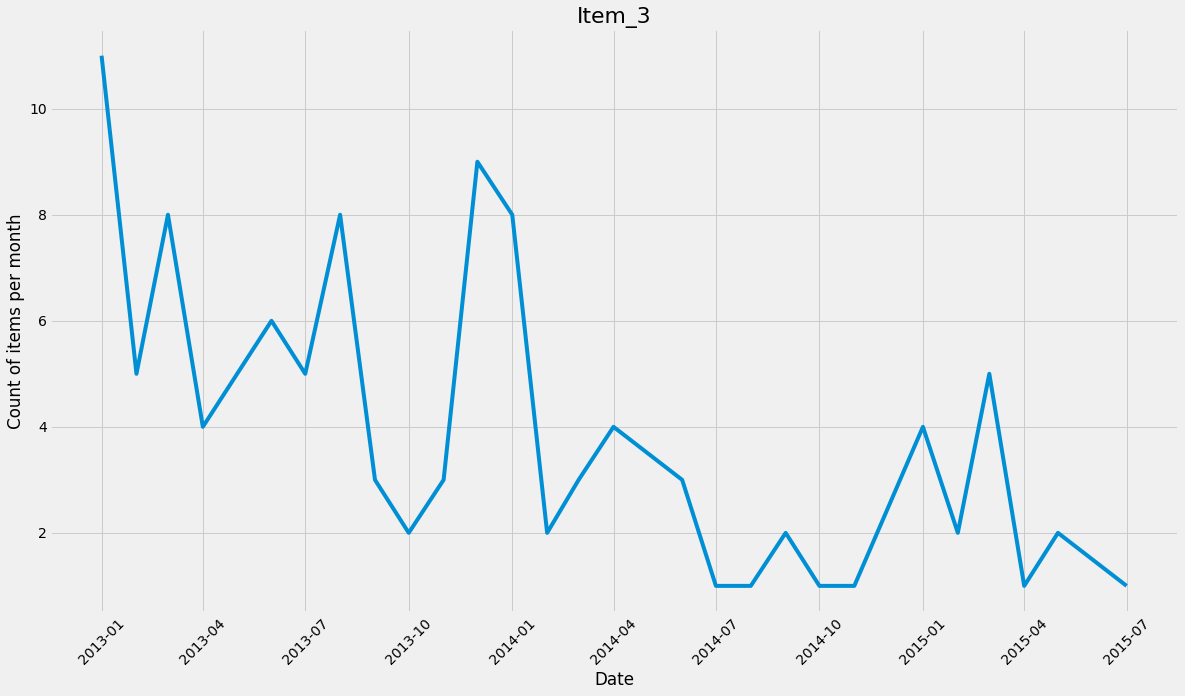

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item_3', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_items.T[28][2][5572], data=train_super_id_sales_items.T[28][2][5572], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

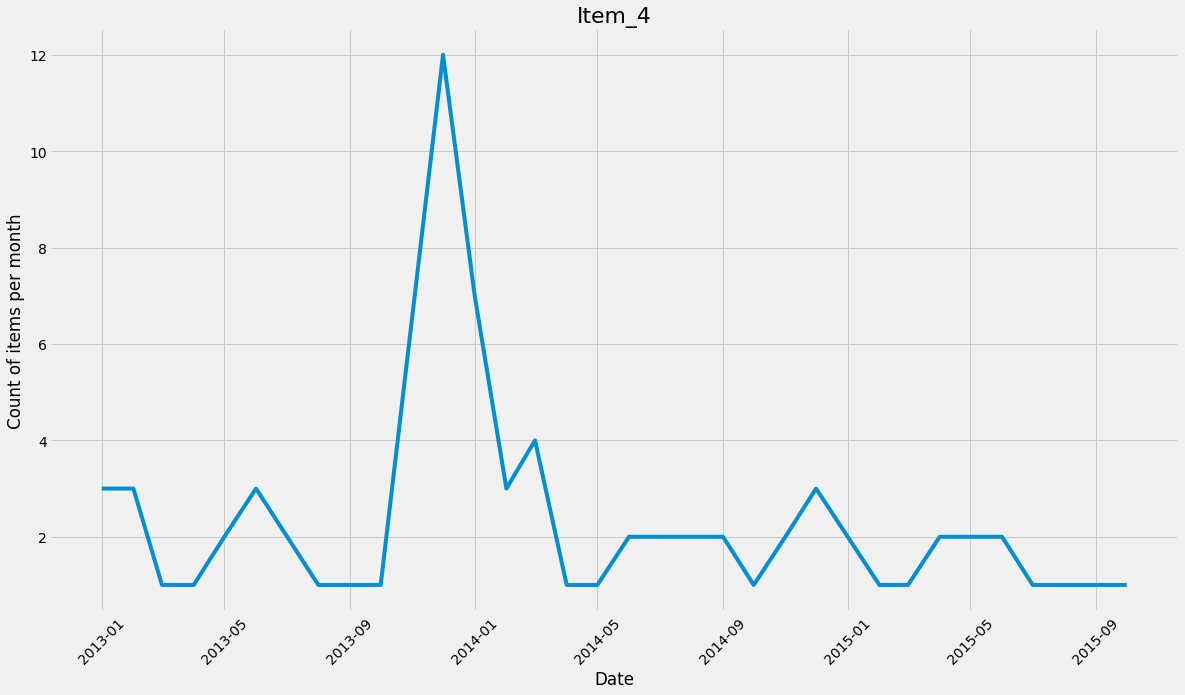

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item_4', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_items.T[15][2][5643], data=train_super_id_sales_items.T[15][2][5643], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

получение средних значений для каждой категории в каждом месяце

In [ ]:
train_super_id_sales_items = train_super_id_sales_items.reset_index(level=0, drop=True)
train_super_id_sales_items = train_super_id_sales_items.groupby(['item_category_id']).sum() / train_super_id_sales_items.groupby(['item_category_id']).count()
train_super_id_sales_items = train_super_id_sales_items.fillna(method='ffill').fillna(method='bfill')

In [ ]:
train_super_id_sales_items

year_month        2013-01-01  2013-02-01  ...  2015-09-01  2015-10-01
item_category_id                          ...                        
0                   1.000000    1.000000  ...    1.328358    1.413793
1                   1.000000    1.000000  ...    1.328358    1.413793
2                   2.522686    2.270992  ...    1.328358    1.413793
3                  10.000000    7.365854  ...    2.704715    2.601966
4                   1.930769    2.000000  ...    2.704715    2.601966
...                      ...         ...  ...         ...         ...
79                  5.178571    3.764706  ...   13.270270   13.358974
80                  5.178571    3.764706  ...   57.211111   13.358974
81                  3.933333    3.363636  ...   57.211111   13.358974
82                 14.463158   13.545455  ...   57.211111   13.358974
83                  7.982143    5.797980  ...    2.855670    3.411765

[84 rows x 34 columns]

заполнение пропущенных значений в таблице магазин-категория

In [ ]:
train_super_id_sales_category_FILLED = train_super_id_sales_category.fillna(train_super_id_sales_items)

In [ ]:
get_mean_na_part(train_super_id_sales_category_FILLED)

0.0

In [ ]:
train_super_id_sales_category_FILLED

year_month                2013-01-01  2013-02-01  ...  2015-09-01  2015-10-01
shop_id item_category_id                          ...                        
0       0                   1.000000    1.000000  ...    1.328358    1.413793
        1                   1.000000    1.000000  ...    1.328358    1.413793
        2                  53.000000   52.000000  ...    1.328358    1.413793
        3                  28.000000   24.000000  ...    2.704715    2.601966
        4                  16.000000   22.000000  ...    2.704715    2.601966
...                              ...         ...  ...         ...         ...
59      75                 55.000000   37.000000  ...   11.000000   12.000000
        77                  1.886275    1.860215  ...    1.000000    1.066667
        79                  5.178571    3.000000  ...   12.000000   13.000000
        80                  5.178571    3.764706  ...   22.000000   13.358974
        83                 16.000000    1.000000  ...    7.000000    9.000000

[3271 rows x 34 columns]

заполненная таблица для магазинов

In [ ]:
train_super_id_sales_shop_category_FILLED=train_super_id_sales_category_FILLED.reset_index().drop(columns=['item_category_id']).groupby(['shop_id']).sum()

In [ ]:
train_super_id_sales_shop_category_FILLED

year_month    2013-01-01  ...   2015-10-01
shop_id                   ...             
0            5617.250000  ...   212.527028
1            2952.048602  ...   102.987639
2            1216.664794  ...   876.711112
3             860.262073  ...   659.222459
4            2185.073031  ...   900.423853
5             179.431341  ...  1091.555940
6            3754.338945  ...  1867.619766
7            2580.893600  ...  1244.843612
8            1463.000000  ...    89.521407
9              97.421620  ...  3238.838918
10           1003.719451  ...   482.780525
11            123.282786  ...   171.545853
12            966.821844  ...  4249.339910
13           1238.935586  ...   187.323072
14           1852.543728  ...  1042.324349
15           2805.977196  ...  1281.150039
16           3046.341236  ...  1029.117765
17            162.927534  ...   212.339938
18           2921.139878  ...  1276.409281
19           3114.621685  ...  1482.041591
20             31.335458  ...  2615.895090
21           1576.993292  ...  1942.353574
22           2000.187825  ...  1405.151613
23           1963.190434  ...    93.804327
24           1866.089849  ...  1259.966648
25           8282.228833  ...  6304.792764
26           2432.958012  ...  1697.915377
27           5578.865107  ...   237.838212
28           7128.248643  ...  3047.215643
29           2897.448252  ...   259.579630
30           3041.154343  ...   243.607583
31          10204.591236  ...  6144.855079
32           1293.292825  ...   199.238821
33            157.828898  ...   204.703721
34            162.384313  ...   408.379661
35           2209.402744  ...  1457.511998
36            128.697423  ...   330.000000
37           2476.168414  ...   900.852908
38           1794.511404  ...  1149.770667
39            174.217141  ...  1025.452554
40            107.333654  ...   170.061319
41           2075.583967  ...   804.185734
42           4024.975219  ...  4533.576074
43           1827.033316  ...   216.853152
44           1788.498711  ...   847.711650
45           1708.539275  ...   736.401706
46           3441.876969  ...  1357.552089
47           2207.327042  ...  1811.786146
48            163.027822  ...  1127.451960
49            166.044521  ...   672.098690
50           3486.837828  ...   983.493693
51           2813.749671  ...   231.778778
52           1885.386614  ...   908.644479
53           2142.962306  ...  1098.750122
54           9444.707168  ...   244.625902
55             31.495818  ...  1984.358974
56           3317.397484  ...  1328.948142
57            194.579763  ...  2362.180769
58            189.268966  ...  1495.882029
59           2100.136276  ...   826.462002

[60 rows x 34 columns]

In [ ]:
get_mean_na_part(train_super_id_sales_shop_category_FILLED)

0.0

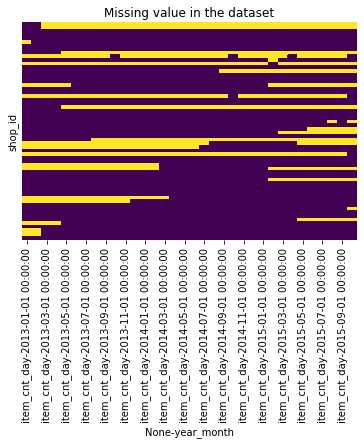

In [ ]:
plot_missing_values_heatmap(train_super_id_sales_shop)

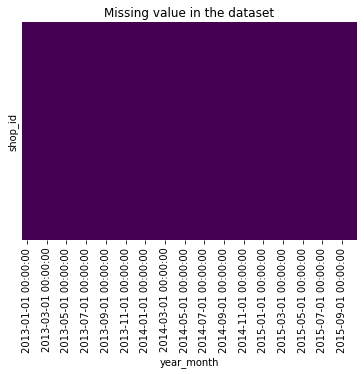

In [ ]:
plot_missing_values_heatmap(train_super_id_sales_shop_category_FILLED)

здесь можно посмотреть на пропуски и порассуждать о том, какими способами их можно заполнить (среднее за соотв месяц внутри категории по известным рядам по всем магазинам, например)

Попрогнозируем:

In [ ]:
train_super_id_sales_shop.head()

item_cnt_day                        ...                                 
year_month   2013-01-01 2013-02-01 2013-03-01  ... 2015-08-01 2015-09-01 2015-10-01
shop_id                                        ...                                 
0                5578.0     6127.0        NaN  ...        NaN        NaN        NaN
1                2947.0     3364.0        NaN  ...        NaN        NaN        NaN
2                1146.0      488.0      753.0  ...      942.0      822.0      727.0
3                 767.0      798.0      959.0  ...      666.0      745.0      613.0
4                2114.0     2025.0     2060.0  ...      947.0      732.0      831.0

[5 rows x 34 columns]

In [ ]:
train_super_id_sales_shop.T.values.shape

(34, 60)

In [ ]:
train_super_id_sales_shop.T.isnull().sum()

shop_id
0     32
1     32
2      0
3      0
4      0
5      1
6      0
7      0
8     30
9     30
10     1
11    33
12     0
13    14
14     0
15     0
16     0
17    14
18     0
19     0
20    32
21     0
22     0
23    30
24     0
25     0
26     0
27     2
28     0
29     5
30     8
31     0
32    27
33    25
34    18
35     0
36    33
37     0
38     0
39    14
40    23
41     0
42     0
43     9
44     0
45     0
46     0
47     0
48    15
49    11
50     0
51     1
52     0
53     0
54     6
55     4
56     0
57     2
58     2
59     0
dtype: int64

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(train_super_id_sales_shop.T)
IterativeImputer(random_state=0)
a=imp_mean.transform(train_super_id_sales_shop.T)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



In [ ]:
train_super_id_sales_shop_iterative=pd.DataFrame(a, columns=train_super_id_sales_shop.T.columns)

In [ ]:
train_super_id_sales_shop_iterative=round(train_super_id_sales_shop_iterative)

In [ ]:
train_super_id_sales_shop_iterative

shop_id      0       1       2       3   ...      56      57      58      59
0        5578.0  2947.0  1146.0   767.0  ...  3238.0  5351.0  2935.0  2017.0
1        6127.0  3364.0   488.0   798.0  ...  2655.0  5791.0  3158.0  1897.0
2        5877.0  3174.0   753.0   959.0  ...  3099.0  6586.0  3773.0  2028.0
3        6337.0  3523.0   583.0   647.0  ...  2153.0  5493.0  2831.0  1388.0
4        6202.0  3421.0   553.0   710.0  ...  2140.0  5233.0  2308.0  1374.0
5        5987.0  3258.0   832.0   784.0  ...  3105.0  5987.0  2972.0  1707.0
6        6050.0  3305.0   807.0   721.0  ...  3294.0  5827.0  3122.0  1747.0
7        5877.0  3174.0   875.0   890.0  ...  3311.0  5413.0  2863.0  2048.0
8        6129.0  3366.0   945.0  1026.0  ...  2829.0  5213.0  2735.0  2008.0
9        6352.0  3535.0   795.0   793.0  ...  2375.0  5686.0  3022.0  1751.0
10       6130.0  3366.0   862.0   970.0  ...  2837.0  5242.0  2947.0  1953.0
11       5982.0  3254.0  1322.0  1134.0  ...  3547.0  9483.0  5599.0  2390.0
12       5890.0  3184.0   890.0   968.0  ...  2983.0  4962.0  2683.0  1491.0
13       6354.0  3536.0   911.0   873.0  ...  2347.0  5157.0  2832.0  1420.0
14       6237.0  3448.0   990.0  1105.0  ...  2280.0  5026.0  2912.0  1467.0
15       6531.0  3671.0   791.0   685.0  ...  1655.0  4435.0  2361.0  1228.0
16       6392.0  3566.0   910.0   776.0  ...  1991.0  3911.0  1981.0  1184.0
17       6196.0  3417.0   957.0   828.0  ...  2583.0  3788.0  2089.0  1157.0
18       6402.0  3573.0   838.0   758.0  ...  2361.0  3813.0  2230.0  1082.0
19       6187.0  3409.0   956.0   902.0  ...  3012.0  3801.0  2744.0  1244.0
20       6582.0  3709.0   920.0   960.0  ...  1879.0  3701.0  2214.0  1161.0
21       6601.0  3724.0   945.0   805.0  ...  1881.0  3802.0  2060.0  1211.0
22       6369.0  3548.0  1192.0  1063.0  ...  2473.0  3491.0  2303.0  1610.0
23       6307.0  3500.0  1921.0  1275.0  ...  2853.0  6839.0  5081.0  1939.0
24       6256.0  3462.0   987.0   977.0  ...  2444.0  4143.0  2519.0  1293.0
25       6696.0  3796.0   907.0   738.0  ...  1691.0  3540.0  2360.0  1206.0
26       6650.0  3761.0   762.0   741.0  ...  1393.0  3113.0  2359.0  1199.0
27       7306.0  4259.0   859.0   740.0  ...  1237.0  2860.0  1710.0  1054.0
28       6920.0  3967.0   843.0   731.0  ...  1315.0  2408.0  1378.0   916.0
29       6701.0  3800.0   804.0   672.0  ...  1566.0  2440.0  1554.0   913.0
30       6676.0  3781.0   785.0   535.0  ...  1491.0  2352.0  1689.0   992.0
31       6613.0  3733.0   942.0   666.0  ...  1604.0  2780.0  1738.0  1214.0
32       7336.0  4283.0   822.0   745.0  ...  1194.0  2266.0  1319.0   914.0
33       7111.0  4112.0   727.0   613.0  ...  1263.0  2316.0  1446.0   790.0

[34 rows x 60 columns]

Заполнение пропуков

In [ ]:
train_super_id_sales_shop=train_super_id_sales_shop.fillna(round(train_super_id_sales_shop.mean(axis=0)))
train_super_id_sales_shop

year_month  2013-01-01  2013-02-01  ...  2015-09-01  2015-10-01
shop_id                             ...                        
0               5578.0      6127.0  ...      1694.0      1615.0
1               2947.0      3364.0  ...      1694.0      1615.0
2               1146.0       488.0  ...       822.0       727.0
3                767.0       798.0  ...       745.0       613.0
4               2114.0      2025.0  ...       732.0       831.0
5               2922.0       877.0  ...      1092.0      1052.0
6               3686.0      4007.0  ...      1725.0      1802.0
7               2495.0      2513.0  ...      1287.0      1212.0
8               1463.0      1156.0  ...      1694.0      1615.0
9               2922.0      2785.0  ...      1694.0      3186.0
10               935.0      1026.0  ...       519.0       428.0
11              2922.0      2785.0  ...      1694.0      1615.0
12               842.0      1209.0  ...      5215.0      4181.0
13              1178.0      1036.0  ...      1694.0      1615.0
14              1777.0      1795.0  ...      1094.0      1002.0
15              2724.0      2746.0  ...      1267.0      1243.0
16              2978.0      2614.0  ...      1067.0       963.0
17              2922.0      2785.0  ...      1694.0      1615.0
18              2856.0      3341.0  ...      1404.0      1211.0
19              3038.0      2834.0  ...      1231.0      1449.0
20              2922.0      2785.0  ...      1694.0      2611.0
21              1495.0      1854.0  ...      1900.0      1912.0
22              1924.0      2447.0  ...      1432.0      1336.0
23              1948.0      1941.0  ...      1694.0      1615.0
24              1768.0      1782.0  ...      1492.0      1227.0
25              8215.0      7934.0  ...      5893.0      6247.0
26              2331.0      2597.0  ...      1553.0      1409.0
27              5548.0      4546.0  ...        -1.0      1615.0
28              7057.0      5438.0  ...      2979.0      3018.0
29              2820.0      2834.0  ...      1694.0      1615.0
30              2978.0      2717.0  ...      1694.0      1615.0
31             10173.0     11160.0  ...      6505.0      6112.0
32              1238.0      1494.0  ...      1694.0      1615.0
33              2922.0      2785.0  ...      1694.0      1615.0
34              2922.0      2785.0  ...       420.0       383.0
35              2127.0      2205.0  ...      1548.0      1418.0
36              2922.0      2785.0  ...      1694.0       330.0
37              2399.0      2216.0  ...       978.0       833.0
38              1704.0      1670.0  ...      1345.0      1110.0
39              2922.0      2785.0  ...       907.0       997.0
40              2922.0      2785.0  ...      1694.0      1615.0
41              1998.0      1856.0  ...       686.0       742.0
42              3991.0      3965.0  ...      4237.0      4491.0
43              1759.0      2033.0  ...      1694.0      1615.0
44              1708.0      1823.0  ...       759.0       779.0
45              1634.0      1530.0  ...       654.0       702.0
46              3363.0      2660.0  ...      1357.0      1320.0
47              2115.0      1824.0  ...      1926.0      1776.0
48              2922.0      2785.0  ...      1101.0      1111.0
49              2922.0      2785.0  ...       567.0       648.0
50              3406.0      3054.0  ...       906.0       949.0
51              2748.0      2284.0  ...       624.0      1615.0
52              1812.0      1737.0  ...      1086.0       847.0
53              2055.0      1906.0  ...      1229.0      1061.0
54              9386.0      8075.0  ...      1694.0      1615.0
55              2922.0      2785.0  ...      6867.0      1972.0
56              3238.0      2655.0  ...      1194.0      1263.0
57              2922.0      2785.0  ...      2266.0      2316.0
58              2922.0      2785.0  ...      1319.0      1446.0
59              2017.0      1897.0  ...       914.0       790.0

[60 rows x 34 columns]

In [ ]:
train_super_id_sales_shop.T

shop_id         0       1       2       3   ...      56      57      58      59
year_month                                  ...                                
2013-01-01  5578.0  2947.0  1146.0   767.0  ...  3238.0  2922.0  2922.0  2017.0
2013-02-01  6127.0  3364.0   488.0   798.0  ...  2655.0  2785.0  2785.0  1897.0
2013-03-01  3199.0  3199.0   753.0   959.0  ...  3099.0  6586.0  3773.0  2028.0
2013-04-01  2330.0  2330.0   583.0   647.0  ...  2153.0  5493.0  2831.0  1388.0
2013-05-01  2377.0  2377.0   553.0   710.0  ...  2140.0  5233.0  2308.0  1374.0
2013-06-01  2726.0  2726.0   832.0   784.0  ...  3105.0  5987.0  2972.0  1707.0
2013-07-01  2543.0  2543.0   807.0   721.0  ...  3294.0  5827.0  3122.0  1747.0
2013-08-01  2784.0  2784.0   875.0   890.0  ...  3311.0  5413.0  2863.0  2048.0
2013-09-01  2963.0  2963.0   945.0  1026.0  ...  2829.0  5213.0  2735.0  2008.0
2013-10-01  2773.0  2773.0   795.0   793.0  ...  2375.0  5686.0  3022.0  1751.0
2013-11-01  2889.0  2889.0   862.0   970.0  ...  2837.0  5242.0  2947.0  1953.0
2013-12-01  3986.0  3986.0  1322.0  1134.0  ...  3547.0  9483.0  5599.0  2390.0
2014-01-01  2541.0  2541.0   890.0   968.0  ...  2983.0  4962.0  2683.0  1491.0
2014-02-01  2384.0  2384.0   911.0   873.0  ...  2347.0  5157.0  2832.0  1420.0
2014-03-01  2402.0  2402.0   990.0  1105.0  ...  2280.0  5026.0  2912.0  1467.0
2014-04-01  1971.0  1971.0   791.0   685.0  ...  1655.0  4435.0  2361.0  1228.0
2014-05-01  1996.0  1996.0   910.0   776.0  ...  1991.0  3911.0  1981.0  1184.0
2014-06-01  1988.0  1988.0   957.0   828.0  ...  2583.0  3788.0  2089.0  1157.0
2014-07-01  1826.0  1826.0   838.0   758.0  ...  2361.0  3813.0  2230.0  1082.0
2014-08-01  2014.0  2014.0   956.0   902.0  ...  3012.0  3801.0  2744.0  1244.0
2014-09-01  1984.0  1984.0   920.0   960.0  ...  1879.0  3701.0  2214.0  1161.0
2014-10-01  2066.0  2066.0   945.0   805.0  ...  1881.0  3802.0  2060.0  1211.0
2014-11-01  2357.0  2357.0  1192.0  1063.0  ...  2473.0  3491.0  2303.0  1610.0
2014-12-01  3375.0  3375.0  1921.0  1275.0  ...  2853.0  6839.0  5081.0  1939.0
2015-01-01  2219.0  2219.0   987.0   977.0  ...  2444.0  4143.0  2519.0  1293.0
2015-02-01  1791.0  1791.0   907.0   738.0  ...  1691.0  3540.0  2360.0  1206.0
2015-03-01  1783.0  1783.0   762.0   741.0  ...  1393.0  3113.0  2359.0  1199.0
2015-04-01  1656.0  1656.0   859.0   740.0  ...  1237.0  2860.0  1710.0  1054.0
2015-05-01  1643.0  1643.0   843.0   731.0  ...  1315.0  2408.0  1378.0   916.0
2015-06-01  1491.0  1491.0   804.0   672.0  ...  1566.0  2440.0  1554.0   913.0
2015-07-01  1469.0  1469.0   785.0   535.0  ...  1491.0  2352.0  1689.0   992.0
2015-08-01  1573.0  1573.0   942.0   666.0  ...  1604.0  2780.0  1738.0  1214.0
2015-09-01  1694.0  1694.0   822.0   745.0  ...  1194.0  2266.0  1319.0   914.0
2015-10-01  1615.0  1615.0   727.0   613.0  ...  1263.0  2316.0  1446.0   790.0

[34 rows x 60 columns]

# Model 0

In [ ]:
#Option1
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17)
for train_index, test_index in tscv.split(train_super_id_sales_shop.T.values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
    mae_cv.append(mae(np.squeeze(X_test, axis=0).astype(int), X_train[-1].astype(int)))
    rmse_cv.append(rmse(np.squeeze(X_test, axis=0).astype(int), X_train[-1].astype(int)))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [24]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] TEST: [25]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] TEST: [26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 1

In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(368.3117647058823, 619.8770277057529)

In [ ]:
#Option2
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17)
for train_index, test_index in tscv.split(train_super_id_sales_shop_category_FILLED.T.values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_super_id_sales_shop_category_FILLED.T.values[train_index], train_super_id_sales_shop_category_FILLED.T.values[test_index]
    mae_cv.append(mae(np.squeeze(X_test, axis=0).astype(int), X_train[-1].astype(int)))
    rmse_cv.append(rmse(np.squeeze(X_test, axis=0).astype(int), X_train[-1].astype(int)))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [24]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] TEST: [25]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] TEST: [26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 1

In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(376.77254901960777, 653.0862980314064)

In [ ]:
#Option3
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17)
for train_index, test_index in tscv.split(train_super_id_sales_shop_iterative.values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_super_id_sales_shop_iterative.values[train_index], train_super_id_sales_shop_iterative.values[test_index]
    mae_cv.append(mae(np.squeeze(X_test, axis=0).astype(int), X_train[-1].astype(int)))
    rmse_cv.append(rmse(np.squeeze(X_test, axis=0).astype(int), X_train[-1].astype(int)))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [24]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] TEST: [25]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] TEST: [26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 1

посмотрим средние значения метрики на кросс-валидации:

In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(354.9647058823529, 604.2492910843301)

# SimpleExpSmoothing

In [ ]:
#Option1
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop.T.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop.T.columns:
    model = SimpleExpSmoothing(np.asarray(train_super_id_sales_shop.T[i].iloc[train_index])).fit(smoothing_level = 0.8, optimized=False)
    forecast = pd.Series(model.forecast(len(test_index)))
    actual = train_super_id_sales_shop.T[i].iloc[test_index]
    mae_cv.append(mae(actual.values, forecast.values))
    rmse_cv.append(rmse(actual.values, forecast.values))

In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(366.1722575415275, 366.1722575415275)

In [ ]:
#Option2
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop_category_FILLED.T.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop_category_FILLED.T.columns:
    model = SimpleExpSmoothing(np.asarray(train_super_id_sales_shop_category_FILLED.T[i].iloc[train_index])).fit(smoothing_level = 0.8, optimized=False)
    forecast = pd.Series(model.forecast(len(test_index)))
    actual = train_super_id_sales_shop_category_FILLED.T[i].iloc[test_index]
    mae_cv.append(mae(actual.values, forecast.values))
    rmse_cv.append(rmse(actual.values, forecast.values))

In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(376.69513957236103, 376.69513957236103)

In [ ]:
#Option3
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop_iterative.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop_iterative.columns:
    model = SimpleExpSmoothing(np.asarray(train_super_id_sales_shop_iterative[i].iloc[train_index])).fit(smoothing_level = 0.8, optimized=False)
    forecast = pd.Series(model.forecast(len(test_index)))
    actual = train_super_id_sales_shop_iterative[i].iloc[test_index]
    mae_cv.append(mae(actual.values, forecast.values))
    rmse_cv.append(rmse(actual.values, forecast.values))

In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(349.94882671589386, 349.94882671589386)

# Sarima model

Generation of combinations of seasonal parameters p, q and q

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
#Option1
warnings.filterwarnings("ignore")
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop.T.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop.T.columns:
    for param in pdq:
      for param_seasonal in seasonal_pdq:
        try:
          mod = sm.tsa.statespace.SARIMAX(train_super_id_sales_shop.T[i].iloc[train_index],
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
          results = mod.fit()
          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
          continue

Выходные данные были обрезаны до нескольких последних строк (5000).
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:444.5607350507384
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:239.22680444521123
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:230.69393126959687
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:70.77439589809106
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:430.85738101518166
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:226.69601838845375
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:231.43112034813748
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:69.87508472669865
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:545.0170952495705
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:295.96928604470617
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:298.6835426968979
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:116.89230911783454
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:495.7862417516359
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:270.99743794065273
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:286.7361499795287
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:111.2035227005749
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:457.797

In [ ]:
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop.T.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop.T.columns:
    mod = sm.tsa.statespace.SARIMAX(train_super_id_sales_shop.T[i].iloc[train_index], order=(0, 1, 0), 
                                    seasonal_order=(1, 0, 0, 12), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False)
    results = mod.fit()
    #print(results.summary().tables[1])
    start = len(train_index)
    #end = start + len(test_index) 
    pred = results.get_prediction(start=start, dynamic=False)
    actual = train_super_id_sales_shop.T[i].iloc[test_index]
    forecast = pred.predicted_mean
    mae_cv.append(mae(actual.values, forecast))
    rmse_cv.append(rmse(actual.values, forecast))


In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(316.77616213414996, 316.77616213414996)

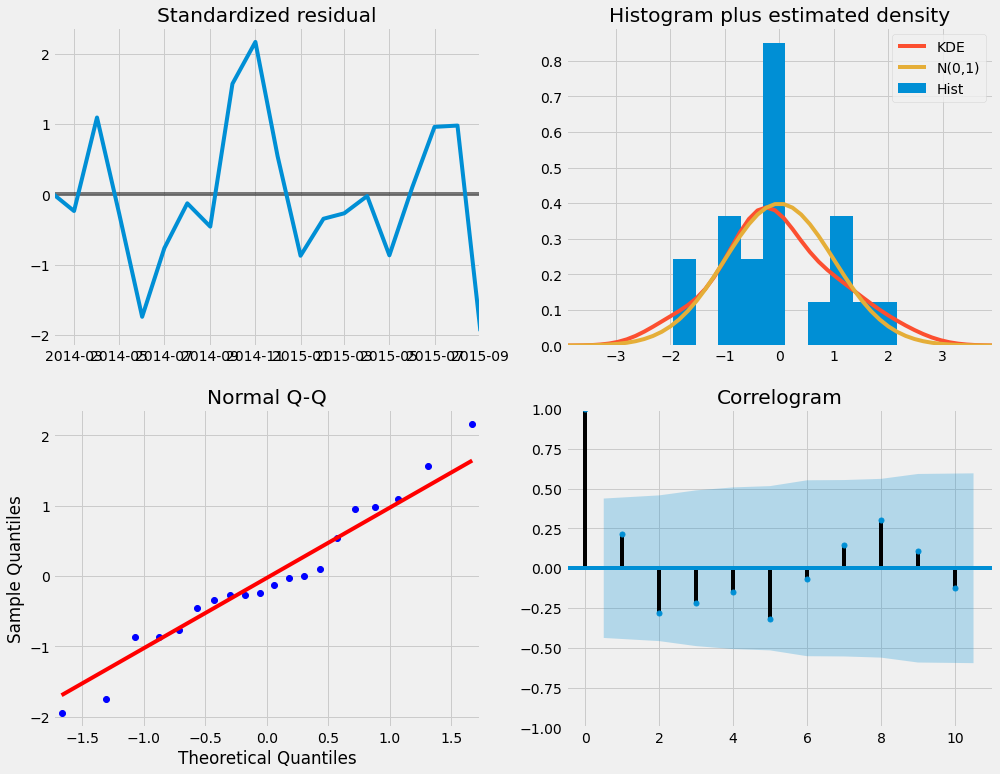

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
#Option2
warnings.filterwarnings("ignore")
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop_category_FILLED.T.values):
  for i in train_super_id_sales_shop_category_FILLED.T.columns:
    for param in pdq:
      for param_seasonal in seasonal_pdq:
        try:
          mod = sm.tsa.statespace.SARIMAX(train_super_id_sales_shop_category_FILLED.T[i].iloc[train_index],
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
          results = mod.fit()
          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
          continue

Выходные данные были обрезаны до нескольких последних строк (5000).
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:418.37228435861863
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:255.9722046653042
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:147.72640405387386
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:34.59974485539475
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:406.2690868805041
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:242.9328422195298
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:144.64181203055742
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:48.733687598053606
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:546.19283459431
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:295.508592030289
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:297.8327345567737
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:116.62817545121005
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:496.69695145241684
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:270.70305743683025
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:286.03556048857075
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:110.75807343780153
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:457.87409

In [ ]:
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop_category_FILLED.T.values):
  for i in train_super_id_sales_shop_category_FILLED.T.columns:
    mod = sm.tsa.statespace.SARIMAX(train_super_id_sales_shop_category_FILLED.T[i].iloc[train_index], order=(0, 1, 0), 
                                    seasonal_order=(0, 1, 0, 12), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False)
    results = mod.fit()
    #print(results.summary().tables[1])
    start = len(train_index)
    #end = start + len(test_index) 
    pred = results.get_prediction(start=start, dynamic=False)
    actual = train_super_id_sales_shop_category_FILLED.T[i].iloc[test_index]
    forecast = pred.predicted_mean
    mae_cv.append(mae(actual.values, forecast))
    rmse_cv.append(rmse(actual.values, forecast))


In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(334.05769963341254, 334.05769963341254)

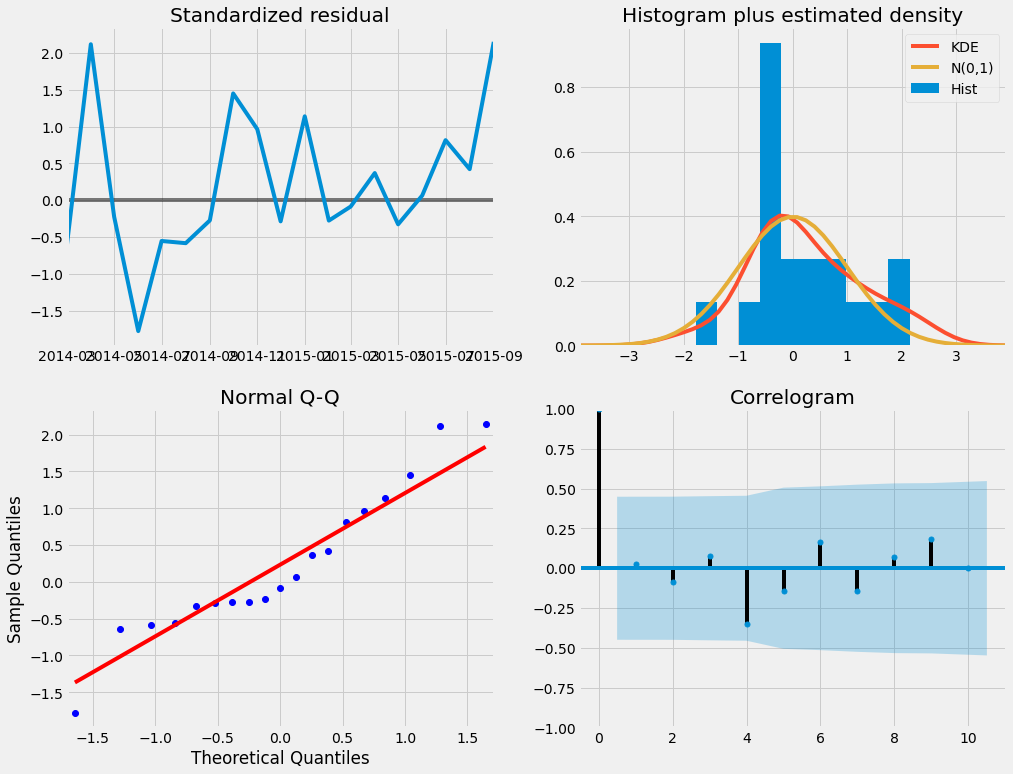

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
#Option3
warnings.filterwarnings("ignore")
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop_iterative.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop_iterative.columns:
    for param in pdq:
      for param_seasonal in seasonal_pdq:
        try:
          mod = sm.tsa.statespace.SARIMAX(train_super_id_sales_shop_iterative[i].iloc[train_index],
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
          results = mod.fit()
          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
          continue

Выходные данные были обрезаны до нескольких последних строк (5000).
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:400.8049697077147
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:207.15260577742748
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:203.76071407649317
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:54.48441120021543
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:386.7760493510759
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:186.42520551260452
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:198.19835528038917
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:56.02927524346365
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:545.0170952495705
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:295.96928604470617
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:298.6835426968979
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:116.89230911783454
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:495.7862417516359
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:270.99743794065273
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:286.7361499795287
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:111.2035227005749
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:457.7971

In [ ]:
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop_iterative.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop_iterative.columns:
    mod = sm.tsa.statespace.SARIMAX(train_super_id_sales_shop_iterative[i].iloc[train_index], order=(1, 0, 1), 
                                    seasonal_order=(1, 0, 0, 12), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False)
    results = mod.fit()
    #print(results.summary().tables[1])
    start = len(train_index)
    #end = start + len(test_index) 
    pred = results.get_prediction(start=start, dynamic=False)
    actual = train_super_id_sales_shop_iterative[i].iloc[test_index]
    forecast = pred.predicted_mean
    mae_cv.append(mae(actual.values, forecast))
    rmse_cv.append(rmse(actual.values, forecast))

In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(302.6925237081659, 302.6925237081659)

In [ ]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                 59   No. Observations:                   33
Model:             SARIMAX(1, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -122.337
Date:                            Tue, 27 Apr 2021   AIC                            252.674
Time:                                    11:40:34   BIC                            256.657
Sample:                                         0   HQIC                           253.452
                                             - 33                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3676      0.263      1.398      0.162      -0.148       0.883
ma.L1          0.8033      0.316   

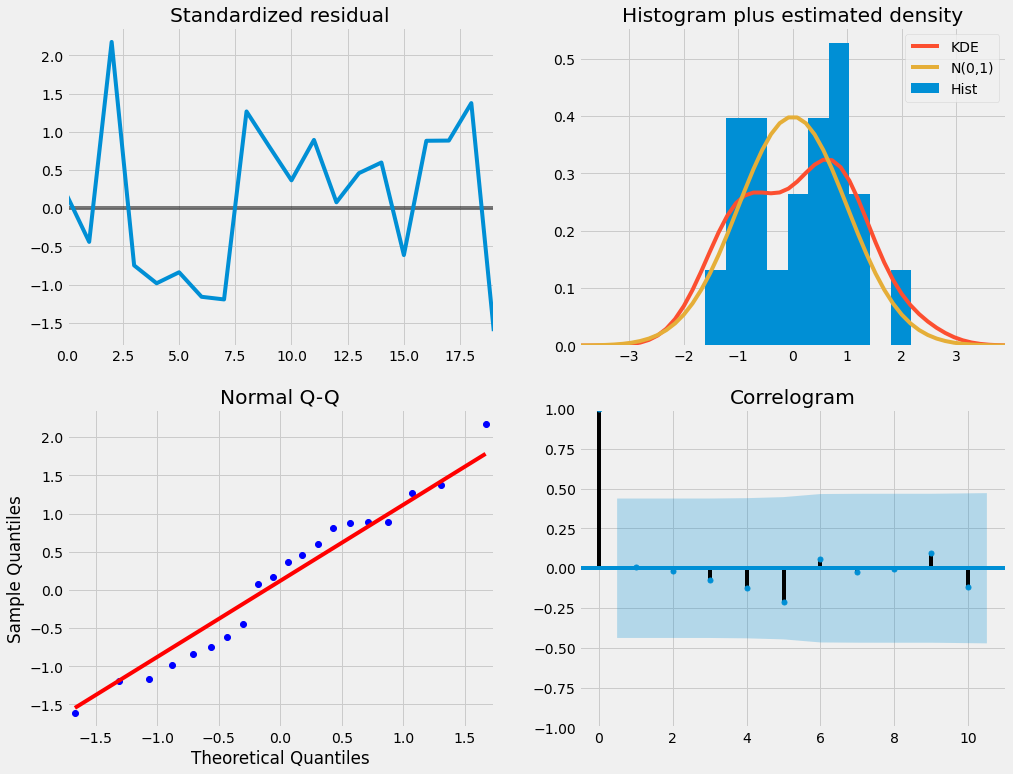

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Some shops don't have sales for all months. This can be a problem if there is there is such store on the test set. Let's check that.

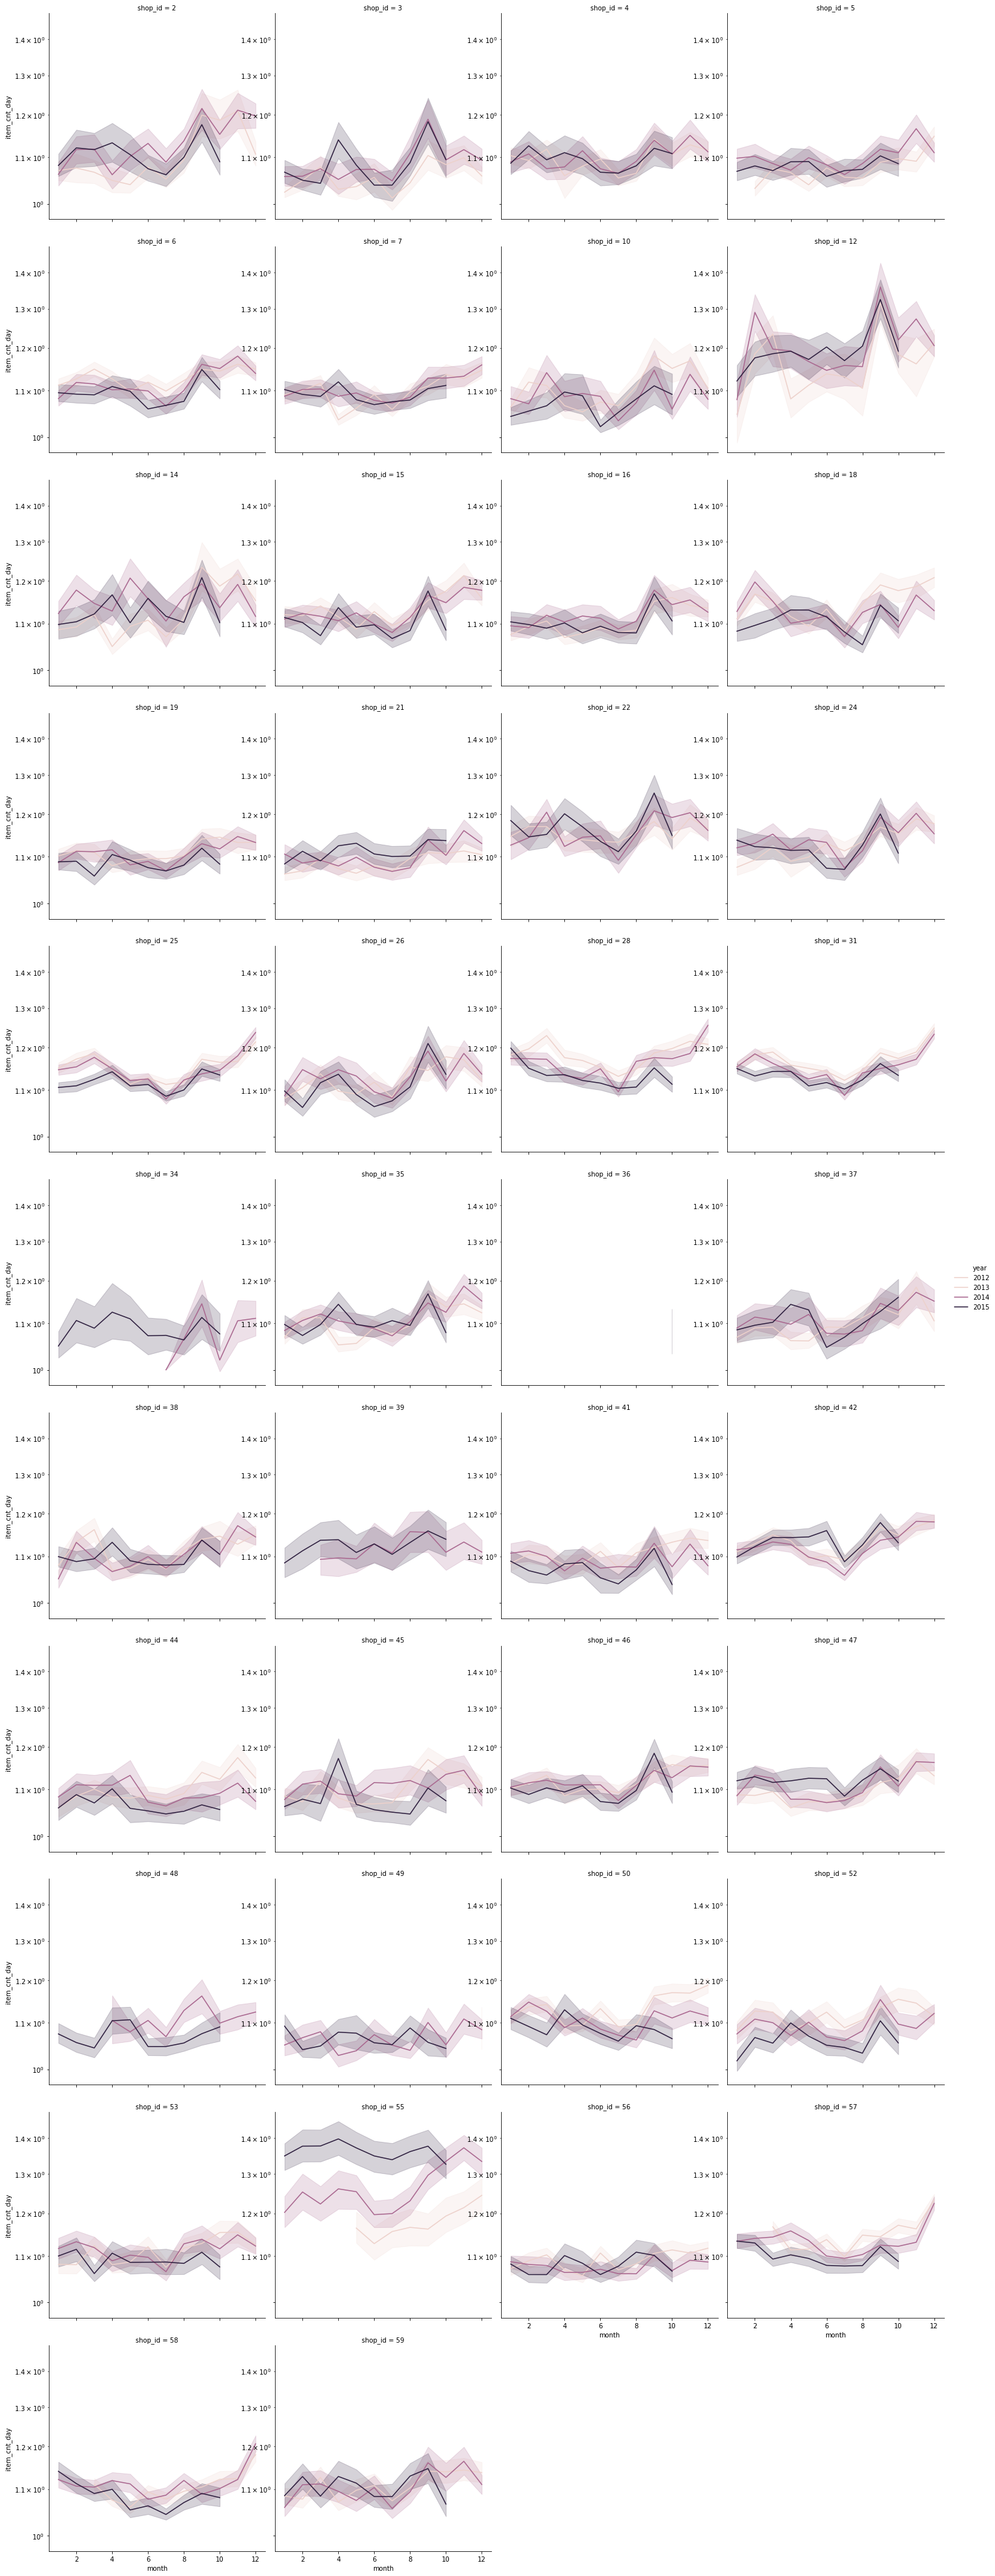

In [ ]:
test_shops = test.shop_id.unique()

g = sns.relplot(x="month",
                y="item_cnt_day",
                kind="line",
                hue="year",
                col="shop_id",
                col_wrap=4,
                data=train[(train.shop_id.isin(test_shops))],
                estimator="mean")

plt.yscale("log")

So shop_id = 36 need some imputation maybe.